**Exploration of Climate Trends and Land Temperature Forecasting Using Autoregressive Integrated Moving Average (Arima)**

**Initial Setup**

1. First, I setup my CoLab environment.

2. Then, I authenticated a Google Drive client to download the file we will be processing in our Spark job.

3. Then, I downloaded the dataset `GlobalLandTemperatureByCountry.csv` and stored it in my drive.


In [ ]:
!pip install prophet
!pip install pyspark
!pip install pyarrow
!pip install -U -q PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=2c9b651bf496673818558c58f7117e0921817474b21941ccf0107ec44f3d96c9
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Import all libraries for Data Exploration

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Download dataset from Google Drive and load into colab using pydrive

In [ ]:
file_list = drive.ListFile({'q': "'1WEWMdTfmeKD-tFrXrOlTtFkKhnoL_fU6' in parents"}).GetList()
for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))

In [ ]:

file_list = drive.ListFile({'q': "'1CZesqIuh4Audmt51M5djtKJwomGacMHK' in parents"}).GetList()
for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))

title: credit_card_churn.xlsx, id: 1t-vvwnGGJgysJH7SW0o7V2mg4U4K7AqY
title: credit_card_churn.csv, id: 1fxqmiR--zW48lBDpmRjw0A1Xxa-3EE3b
title: credit_card_churn.csv, id: 1lc_htt45mbyvIO4BmVeHmgd-66tyK0Xp
title: GlobalAverageTemp Brazil India Kenya UK US.xlsx, id: 1Vn5sJ3fFe0YQxmLclnY6I0dCM5uRm97t
title: Big Data CW1.pdf, id: 1oweMQO8n92eQnxcdJfc_r3Ct20vvfIKk
title: COM739_46456_CW1_Assessment_Rubric.xlsx, id: 1-iTlLn0wm-8yQ9G1IyzMe3MZp1sNoYJe
title: GlobalLandTemperaturesByCountry.csv, id: 189yyCKXRooTgwFprzZ2ZxjDcpGAUDdQa
title: Coursework_Set_Exercise_Student_Worksheet(1).ipynb, id: 1eC3qjy2lCf2LmqtG_pHcVQL-_cH_P8IF


In [ ]:
id='13bxB3TO8Q8yK3qxAQql_Sltm1npK7yZJ'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('GlobalLandTemperaturesByCountry.csv')

In [ ]:
id='189yyCKXRooTgwFprzZ2ZxjDcpGAUDdQa'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('GlobalLandTemperaturesByCountry.csv')

Import necessary Packages

In [ ]:
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import plotly.graph_objects as go


from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
import statsmodels.api as sm
from pyspark import SparkContext, SparkConf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Create the Spark Session

In [ ]:
# Import necessary PySpark modules
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Create the SparkConf and set configuration parameters
conf = SparkConf().set("spark.ui.port", "4050")

# Create the SparkContext
sc = SparkContext(conf=conf)

# Create the SparkSession
spark = SparkSession.builder.getOrCreate()


Read Data into a PySpark Dataframe

In [ ]:
#Read data into a PySpark DataFrame
spark_df = spark.read.csv("GlobalLandTemperaturesByCountry.csv", header=True, inferSchema=True)
print(spark_df.head())

Row(dt=datetime.date(1743, 11, 1), AverageTemperature=4.3839999999999995, AverageTemperatureUncertainty=2.294, Country='Åland')


**Data Exploration Using Pyspark**

Print dataframe Schema to show datatype of each variable

In [ ]:
spark_df.printSchema()

root
 |-- dt: date (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)



Show summary statistics of DataFrame

In [ ]:
spark_df.describe().show()

+-------+------------------+-----------------------------+-----------+
|summary|AverageTemperature|AverageTemperatureUncertainty|    Country|
+-------+------------------+-----------------------------+-----------+
|  count|            544811|                       545550|     577462|
|   mean| 17.19335423293583|           1.0190569003757597|       NULL|
| stddev|10.953966445121187|           1.2019303866334272|       NULL|
|    min|           -37.658|         0.052000000000000005|Afghanistan|
|    max| 38.84200000000001|                       15.003|      Åland|
+-------+------------------+-----------------------------+-----------+



Count number of rows in the dataframe

In [ ]:
spark_df.count()

577462

Count number of columns and show column title

In [ ]:
print(spark_df.columns)
len(spark_df.columns)

['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country']


4

Print Dataframe Dimension

In [ ]:
df_rows = spark_df.count()
df_columns = len(spark_df.columns)
print((df_rows, df_columns))

(577462, 4)


Show first 10 rows of Dataframe

In [ ]:
spark_df.show(10)

+----------+------------------+-----------------------------+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+------------------+-----------------------------+-------+
|1743-11-01|4.3839999999999995|                        2.294|  Åland|
|1743-12-01|              NULL|                         NULL|  Åland|
|1744-01-01|              NULL|                         NULL|  Åland|
|1744-02-01|              NULL|                         NULL|  Åland|
|1744-03-01|              NULL|                         NULL|  Åland|
|1744-04-01|              1.53|                         4.68|  Åland|
|1744-05-01| 6.702000000000001|                        1.789|  Åland|
|1744-06-01|11.609000000000002|                        1.577|  Åland|
|1744-07-01|            15.342|                         1.41|  Åland|
|1744-08-01|              NULL|                         NULL|  Åland|
+----------+------------------+-----------------------------+-------+
only showing top 10 

Show Last 10 rows of Dataframe

In [ ]:
spark_df.tail(10)

[Row(dt=datetime.date(2012, 12, 1), AverageTemperature=24.111, AverageTemperatureUncertainty=0.846, Country='Zimbabwe'),
 Row(dt=datetime.date(2013, 1, 1), AverageTemperature=23.812, AverageTemperatureUncertainty=1.218, Country='Zimbabwe'),
 Row(dt=datetime.date(2013, 2, 1), AverageTemperature=24.075, AverageTemperatureUncertainty=1.286, Country='Zimbabwe'),
 Row(dt=datetime.date(2013, 3, 1), AverageTemperature=23.226000000000006, AverageTemperatureUncertainty=0.564, Country='Zimbabwe'),
 Row(dt=datetime.date(2013, 4, 1), AverageTemperature=21.142, AverageTemperatureUncertainty=0.495, Country='Zimbabwe'),
 Row(dt=datetime.date(2013, 5, 1), AverageTemperature=19.059, AverageTemperatureUncertainty=1.022, Country='Zimbabwe'),
 Row(dt=datetime.date(2013, 6, 1), AverageTemperature=17.613, AverageTemperatureUncertainty=0.473, Country='Zimbabwe'),
 Row(dt=datetime.date(2013, 7, 1), AverageTemperature=17.0, AverageTemperatureUncertainty=0.453, Country='Zimbabwe'),
 Row(dt=datetime.date(2013, 8

How many countries are in the dataset

In [ ]:
Country_List = spark_df.dropDuplicates(['Country']).select("Country")
Country_List.count()

243

**DATA EXPLORATION USING GroupBy, Agg, OrderBy and countDistinct FUNCTIONS**

Create temporary view

In [ ]:
spark_df.createOrReplaceTempView("Countries")

How many observations does each country have

In [ ]:
spark.sql("select Country, count(*) from Countries group by Country order by Country").show()

+-------------------+--------+
|            Country|count(1)|
+-------------------+--------+
|        Afghanistan|    2106|
|             Africa|    1965|
|            Albania|    3239|
|            Algeria|    2721|
|     American Samoa|    1761|
|            Andorra|    3239|
|             Angola|    1878|
|           Anguilla|    2277|
|         Antarctica|     764|
|Antigua And Barbuda|    2277|
|          Argentina|    1901|
|            Armenia|    2802|
|              Aruba|    2277|
|               Asia|    2370|
|          Australia|    1935|
|            Austria|    3239|
|         Azerbaijan|    2460|
|            Bahamas|    3067|
|            Bahrain|    2049|
|       Baker Island|    2265|
+-------------------+--------+
only showing top 20 rows



What Countries have the highest temperatures.

In [ ]:
# SQL query to find the top five hottest countries
top_five_hottest_query = """
    SELECT Country, MAX(AverageTemperature) as AvgTemperature
    FROM Countries
    GROUP BY Country
    ORDER BY AvgTemperature DESC
    LIMIT 5
"""
# Execute the query and show the result
top_five_hottest_df = spark.sql(top_five_hottest_query)
top_five_hottest_df.show()


+--------------------+------------------+
|             Country|    AvgTemperature|
+--------------------+------------------+
|              Kuwait| 38.84200000000001|
|United Arab Emirates|             37.75|
|               Qatar|            37.603|
|             Bahrain|            37.471|
|                Iraq|37.400999999999996|
+--------------------+------------------+



What Countries have the lowest temperatures

In [ ]:
# SQL query to find the top five COLDEST countries
top_five_coldest_query = """
    SELECT Country, MIN(AverageTemperature) as AvgTemperature
    FROM Countries
    GROUP BY Country
    ORDER BY AvgTemperature ASC
    LIMIT 6
"""

# Execute the query and show the result
top_five_coldest_df = spark.sql(top_five_coldest_query)
top_five_coldest_df.show()

+----------+-------------------+
|   Country|     AvgTemperature|
+----------+-------------------+
|Antarctica|               NULL|
| Greenland|            -37.658|
|   Denmark|             -36.83|
|    Russia|            -30.577|
|    Canada|            -28.736|
|  Mongolia|-27.441999999999997|
+----------+-------------------+



**Data Preprocessing**

Checking for Null Values in each column

In [ ]:
null_counts = [count(when(col(column).isNull(), True)).alias(f'isNull_{column}') for column in spark_df.columns]
spark_df.groupBy().agg(*null_counts).show()

+---------+-------------------------+------------------------------------+--------------+
|isNull_dt|isNull_AverageTemperature|isNull_AverageTemperatureUncertainty|isNull_Country|
+---------+-------------------------+------------------------------------+--------------+
|        0|                    32651|                               31912|             0|
+---------+-------------------------+------------------------------------+--------------+



Drop rows with NULL values

In [ ]:
df_1 = spark_df.dropna ()


Confirm NULL values Dropped

In [ ]:
null_counts1 = [count(when(col(column).isNull(), True)).alias(f'isNull_{column}') for column in df_1.columns]
df_1.groupBy().agg(*null_counts1).show()

+---------+-------------------------+------------------------------------+--------------+
|isNull_dt|isNull_AverageTemperature|isNull_AverageTemperatureUncertainty|isNull_Country|
+---------+-------------------------+------------------------------------+--------------+
|        0|                        0|                                   0|             0|
+---------+-------------------------+------------------------------------+--------------+



In [ ]:
df_1.show()

+----------+-------------------+-----------------------------+-------+
|        dt| AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+-------------------+-----------------------------+-------+
|1743-11-01| 4.3839999999999995|                        2.294|  Åland|
|1744-04-01|               1.53|                         4.68|  Åland|
|1744-05-01|  6.702000000000001|                        1.789|  Åland|
|1744-06-01| 11.609000000000002|                        1.577|  Åland|
|1744-07-01|             15.342|                         1.41|  Åland|
|1744-09-01|             11.702|                        1.517|  Åland|
|1744-10-01|              5.477|                        1.862|  Åland|
|1744-11-01|              3.407|                        1.425|  Åland|
|1744-12-01|             -2.181|                        1.641|  Åland|
|1745-01-01|              -3.85|                        1.841|  Åland|
|1745-02-01| -6.574999999999998|                         1.36|  Åland|
|1745-

In [ ]:
df_1.count()

544811

Filter out observations before 01/01/1900 and after 31/12/2010

In [ ]:
# Convert the "dt" column to a date type
# Convert the "dt" column to a date type
df2 = df_1.withColumn("dt", to_date(col("dt"), "dd/MM/yyyy"))


In [ ]:
# Filter out observations before 01/01/1900 and after 2010-12-31
df_filtered = df2.filter((col("dt") >= "1900-01-01") & (col("dt") <= "2010-12-31"))

# Show the filtered DataFrame
df_filtered.show()
df_filtered.tail(5)

+----------+-------------------+-----------------------------+-------+
|        dt| AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+-------------------+-----------------------------+-------+
|1900-01-01|-3.0260000000000002|           0.5379999999999999|  Åland|
|1900-02-01| -8.062999999999999|                        0.657|  Åland|
|1900-03-01|             -3.196|                        0.467|  Åland|
|1900-04-01| 0.7810000000000001|                        0.224|  Åland|
|1900-05-01|  4.960000000000001|                        0.503|  Åland|
|1900-06-01|             12.296|                        1.129|  Åland|
|1900-07-01|             14.712|                        0.879|  Åland|
|1900-08-01|             15.632|                        0.765|  Åland|
|1900-09-01| 10.646999999999998|                        0.484|  Åland|
|1900-10-01|              7.141|           0.5579999999999999|  Åland|
|1900-11-01| 3.2739999999999996|                        0.482|  Åland|
|1900-

[Row(dt=datetime.date(2010, 8, 1), AverageTemperature=18.26, AverageTemperatureUncertainty=0.447, Country='Zimbabwe'),
 Row(dt=datetime.date(2010, 9, 1), AverageTemperature=23.109, AverageTemperatureUncertainty=0.225, Country='Zimbabwe'),
 Row(dt=datetime.date(2010, 10, 1), AverageTemperature=25.943, AverageTemperatureUncertainty=0.369, Country='Zimbabwe'),
 Row(dt=datetime.date(2010, 11, 1), AverageTemperature=25.211, AverageTemperatureUncertainty=0.35600000000000004, Country='Zimbabwe'),
 Row(dt=datetime.date(2010, 12, 1), AverageTemperature=23.756999999999998, AverageTemperatureUncertainty=0.5329999999999999, Country='Zimbabwe')]

In [ ]:
df_filtered.describe().show()

+-------+------------------+-----------------------------+-----------+
|summary|AverageTemperature|AverageTemperatureUncertainty|    Country|
+-------+------------------+-----------------------------+-----------+
|  count|            321053|                       321053|     321053|
|   mean|18.813601212260977|           0.4465441656050559|       NULL|
| stddev|10.492439324394674|           0.3035355166975522|       NULL|
|    min|           -37.177|         0.052000000000000005|Afghanistan|
|    max| 38.70500000000001|                        8.425|      Åland|
+-------+------------------+-----------------------------+-----------+



In [ ]:
df_filtered.count()

321053

Filter out countries except Brazil, India, Kenya, United Kingdom, United States

In [ ]:
# List of countries to keep
countries_to_keep = ['United Kingdom', 'United States', 'Brazil', 'Kenya', 'India']

# Filter out countries not in the specified list
df_filtered_countries = df_filtered.filter(col('Country').isin(countries_to_keep))

# Show the resulting DataFrame
df_filtered_countries.show()
df_filtered_countries.count()

+----------+------------------+-----------------------------+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+------------------+-----------------------------+-------+
|1900-01-01|            25.086|                        0.657| Brazil|
|1900-02-01|            25.259|                        0.573| Brazil|
|1900-03-01|            25.835|                        0.605| Brazil|
|1900-04-01|24.601999999999997|                        0.799| Brazil|
|1900-05-01|            24.393|                        1.133| Brazil|
|1900-06-01|            23.518|                        0.934| Brazil|
|1900-07-01|             23.81|           0.8740000000000001| Brazil|
|1900-08-01|            24.313|                        0.463| Brazil|
|1900-09-01|25.296999999999997|                        0.544| Brazil|
|1900-10-01|            25.799|                        0.517| Brazil|
|1900-11-01|             25.54|                        0.621| Brazil|
|1900-12-01|        

6660

In [ ]:
# Extracting a substring from columns to create month and year variables

from pyspark.sql.functions import substring
spark_df = df_filtered_countries.withColumn("month", substring("dt", 6,2))
spark_df = spark_df.withColumn("year", substring("dt", 1,4))

# Converting string month and hour variables to integer
from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('year', spark_df.year.cast(IntegerType()))

print(spark_df.show(5))

+----------+------------------+-----------------------------+-------+-----+----+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|month|year|
+----------+------------------+-----------------------------+-------+-----+----+
|1900-01-01|            25.086|                        0.657| Brazil|    1|1900|
|1900-02-01|            25.259|                        0.573| Brazil|    2|1900|
|1900-03-01|            25.835|                        0.605| Brazil|    3|1900|
|1900-04-01|24.601999999999997|                        0.799| Brazil|    4|1900|
|1900-05-01|            24.393|                        1.133| Brazil|    5|1900|
+----------+------------------+-----------------------------+-------+-----+----+
only showing top 5 rows

None


**Exploring the DataFrame After Filtering by Date and Country**

How Many Temperature Readingds are there for each country?

In [ ]:
spark_df.createOrReplaceTempView("TempView")

spark.sql("select Country, count(*) from TempView group by Country order by Country").show()

+--------------+--------+
|       Country|count(1)|
+--------------+--------+
|        Brazil|    1332|
|         India|    1332|
|         Kenya|    1332|
|United Kingdom|    1332|
| United States|    1332|
+--------------+--------+



Group the countries in order of highest average temperature

In [ ]:
# SQL query to find the top five hottest countries
top_five_hottest_query = """
    SELECT Country, MAX(AverageTemperature) as AvgTemperature
    FROM TempView
    GROUP BY Country
    ORDER BY AvgTemperature DESC
    LIMIT 5
"""

# Execute the query and show the result
top_five_hottest_df = spark.sql(top_five_hottest_query)
top_five_hottest_df.show()

+--------------+------------------+
|       Country|    AvgTemperature|
+--------------+------------------+
|         India|            31.329|
|         Kenya|            27.178|
|        Brazil|            27.151|
| United States|22.910999999999998|
|United Kingdom|            17.285|
+--------------+------------------+



Group Countries in order of lowest average temperature

In [ ]:
# SQL query to find the top five coldest countries
top_five_coldest_query = """
    SELECT Country, MIN(AverageTemperature) as AvgTemperature
    FROM TempView
    GROUP BY Country
    ORDER BY AvgTemperature ASC
    LIMIT 5
"""

# Execute the query and show the result
top_five_coldest_df = spark.sql(top_five_coldest_query)
top_five_coldest_df.show()

+--------------+-------------------+
|       Country|     AvgTemperature|
+--------------+-------------------+
| United States|             -6.737|
|United Kingdom|-0.5460000000000007|
|         India|             15.629|
|         Kenya|             21.283|
|        Brazil| 21.796999999999997|
+--------------+-------------------+



Box Plot showing distribution of Average Temperature by Country

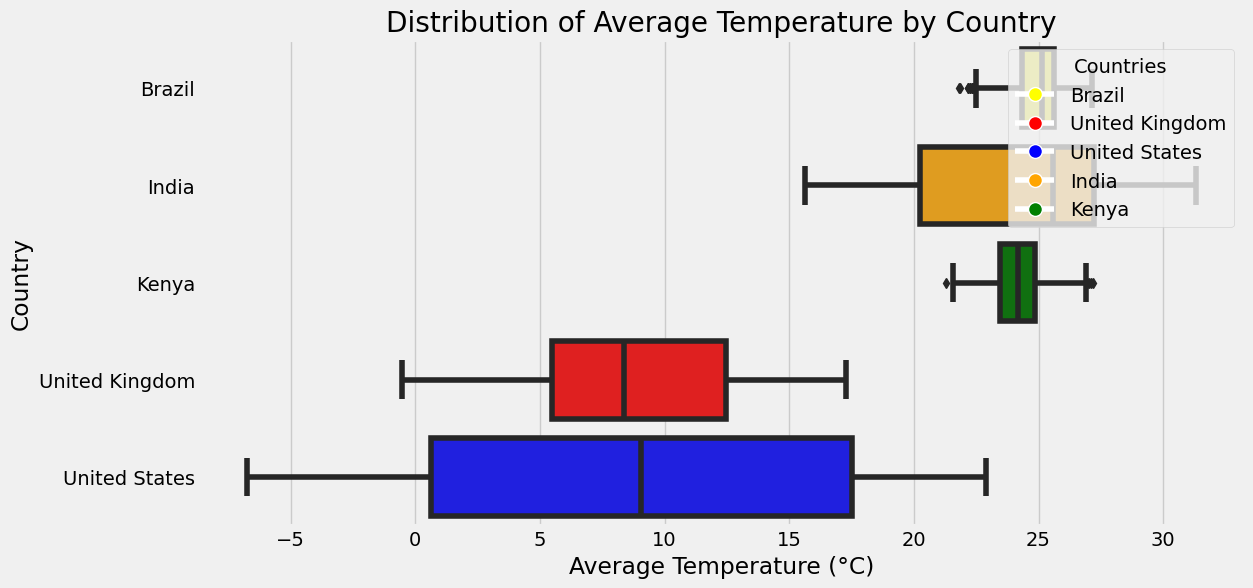

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = spark_df.toPandas()
# List of countries to visualize
countries = ['Brazil', 'United Kingdom', 'United States', 'India', 'Kenya']

# Define colors for each country
colors = {'Brazil': 'yellow', 'United Kingdom': 'red', 'United States': 'blue', 'India': 'orange', 'Kenya': 'green'}

# Create a horizontal box plot for the distribution of average temperature for each country
plt.figure(figsize=(12, 6))
sns.boxplot(x='AverageTemperature', y='Country', data=pandas_df, palette=colors)

# Add legend
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[c], markersize=10, label=c) for c in countries]
plt.legend(handles=legend_labels, title='Countries', loc='upper right')

plt.title('Distribution of Average Temperature by Country')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Country')
plt.show()


With the box plot I am able to better understand the spread for each country and also spot outliers.

Average Land Temperature Change Over the Years

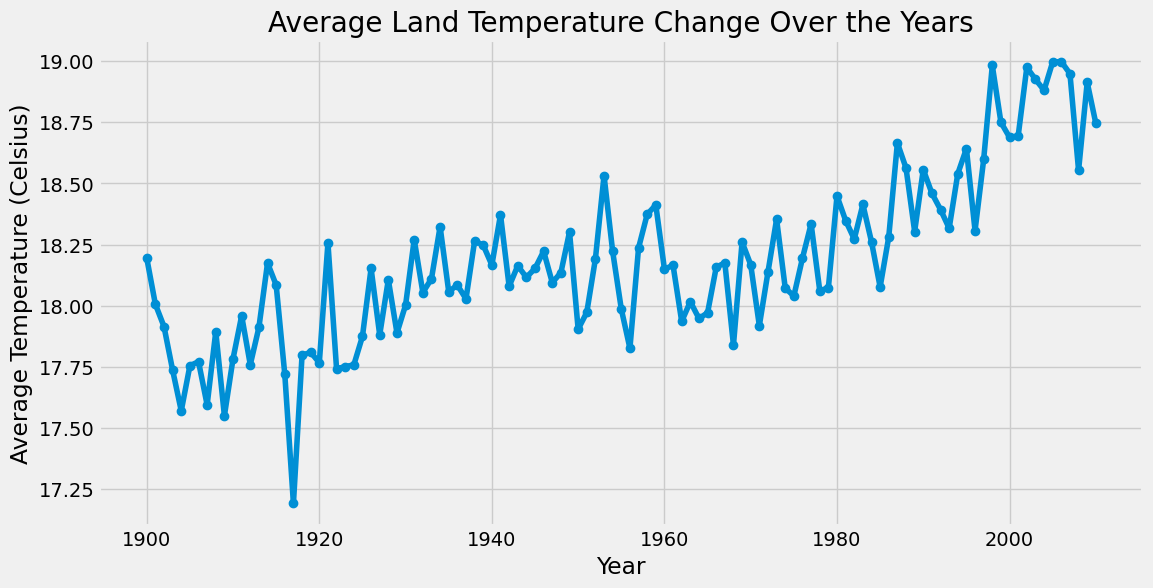

In [ ]:
# Group by year and calculate the average temperature
average_temp_by_year = spark_df.groupBy('Year').avg('AverageTemperature').orderBy('Year')

# Convert result to Pandas
pandas_avgtemp = average_temp_by_year.toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(pandas_avgtemp['Year'], pandas_avgtemp['avg(AverageTemperature)'], marker='o', linestyle='-')
plt.title('Average Land Temperature Change Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Temperature (Celsius)')
plt.grid(True)
plt.show()


The plot depicts a steady increase in average global land temperature over the years and this is in line with the trend of Global warming.

Scatter plot with AverageTemperature and AverageTemperatureUncertainty

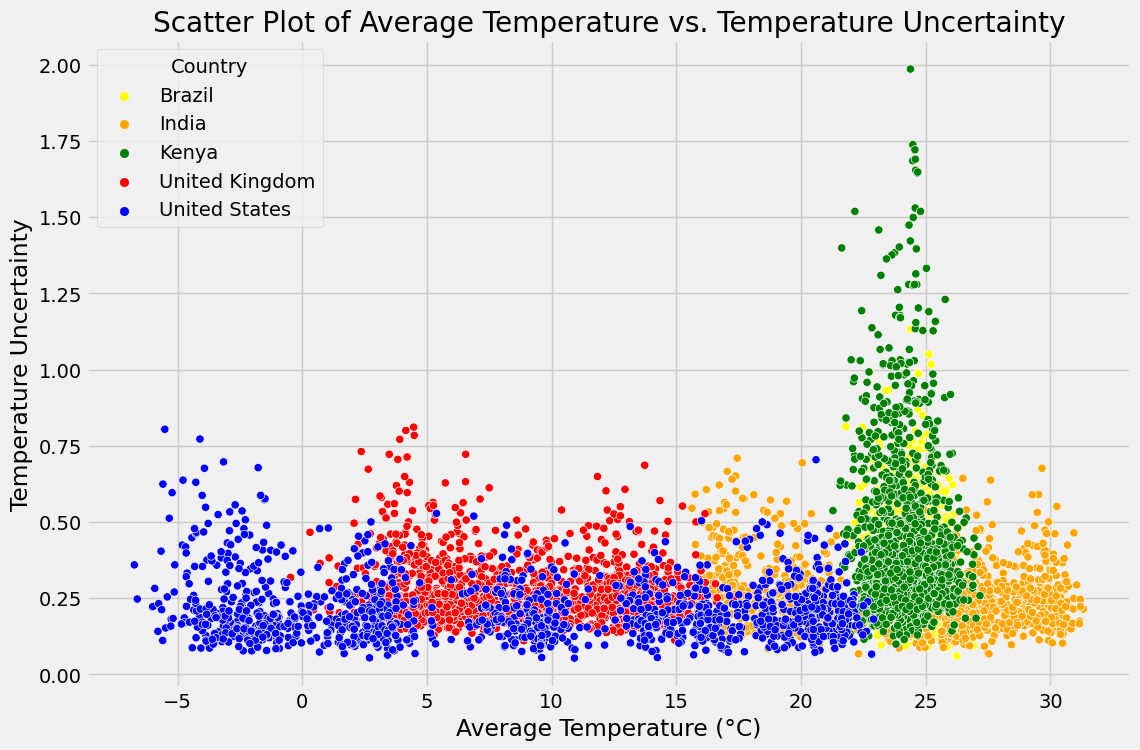

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of countries to visualize
countries = ['Brazil', 'United Kingdom', 'United States', 'India', 'Kenya']

# Define colors for each country
colors = {'Brazil': 'yellow', 'United Kingdom': 'red', 'United States': 'blue', 'India': 'orange', 'Kenya': 'green'}

# Create a scatter plot with AverageTemperature and AverageTemperatureUncertainty
plt.figure(figsize=(12, 8))
sns.scatterplot(x='AverageTemperature', y='AverageTemperatureUncertainty', hue='Country', data=pandas_df, palette=colors)
plt.title('Scatter Plot of Average Temperature vs. Temperature Uncertainty')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Temperature Uncertainty')
plt.show()




The Scatter Plot depicts the relationship between temperature and temperature uncertainty accross the five countries and helps identify temperature trends and temperature variations.

Average Temperature Distribution

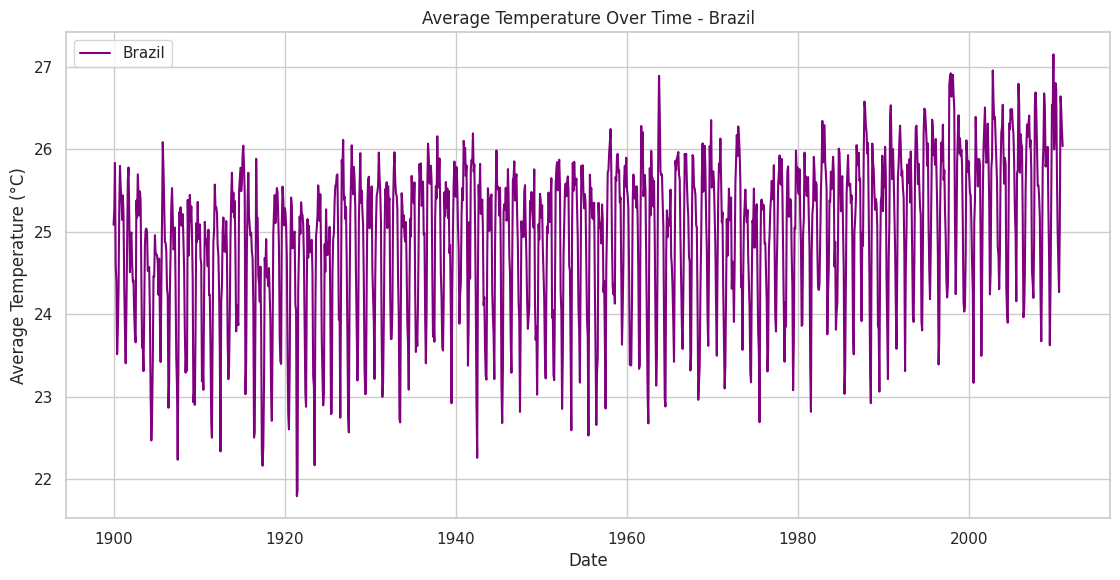

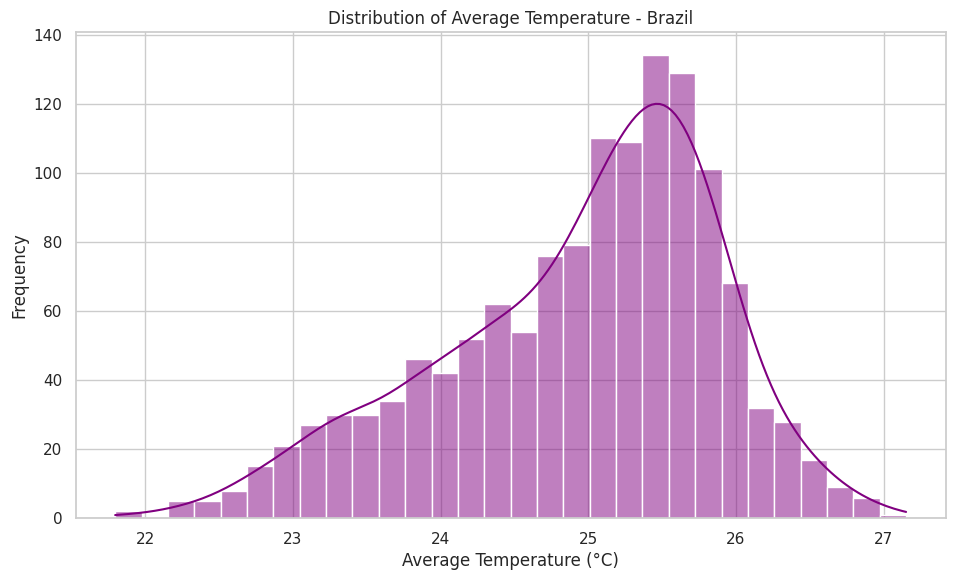

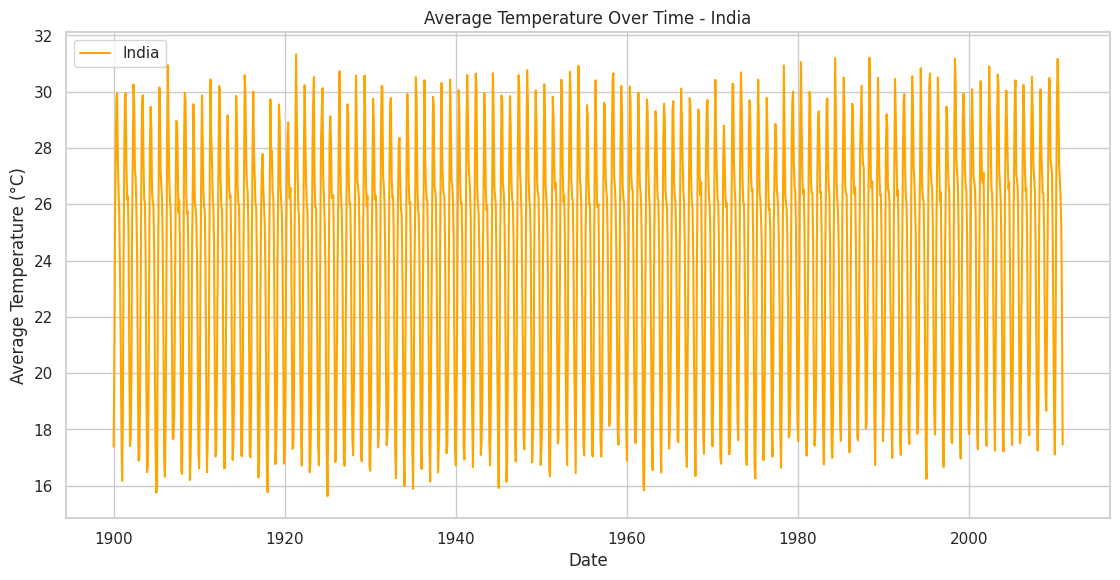

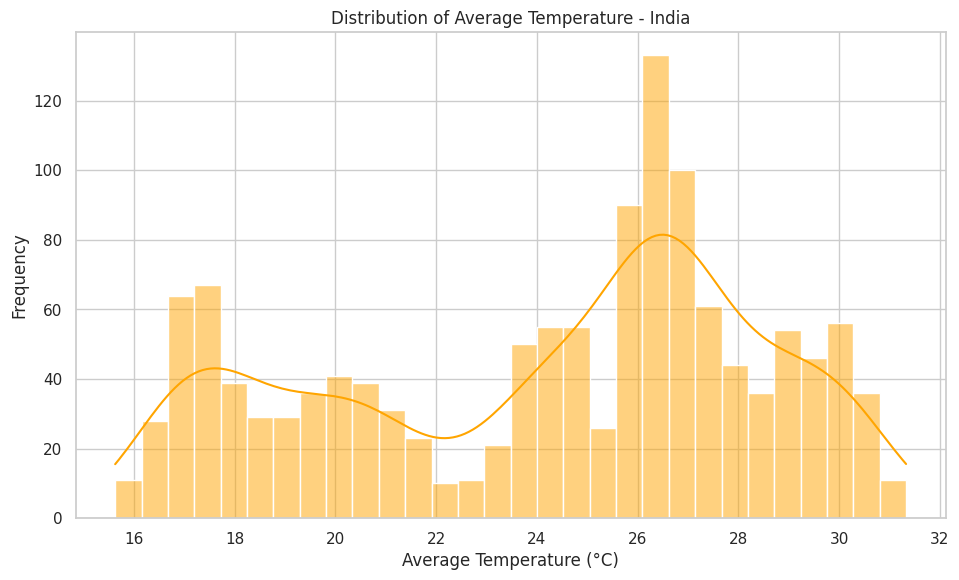

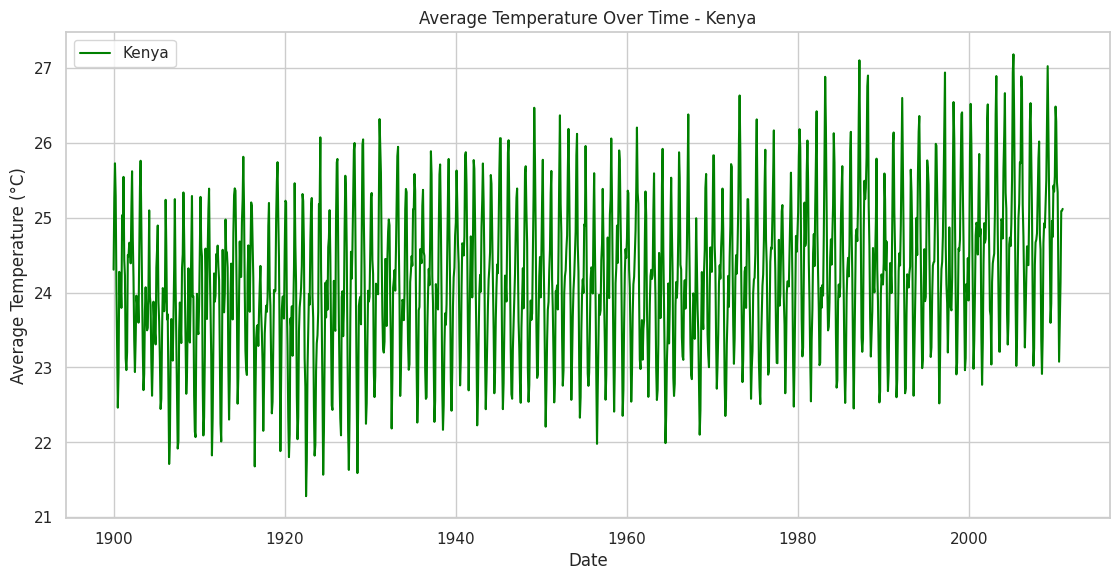

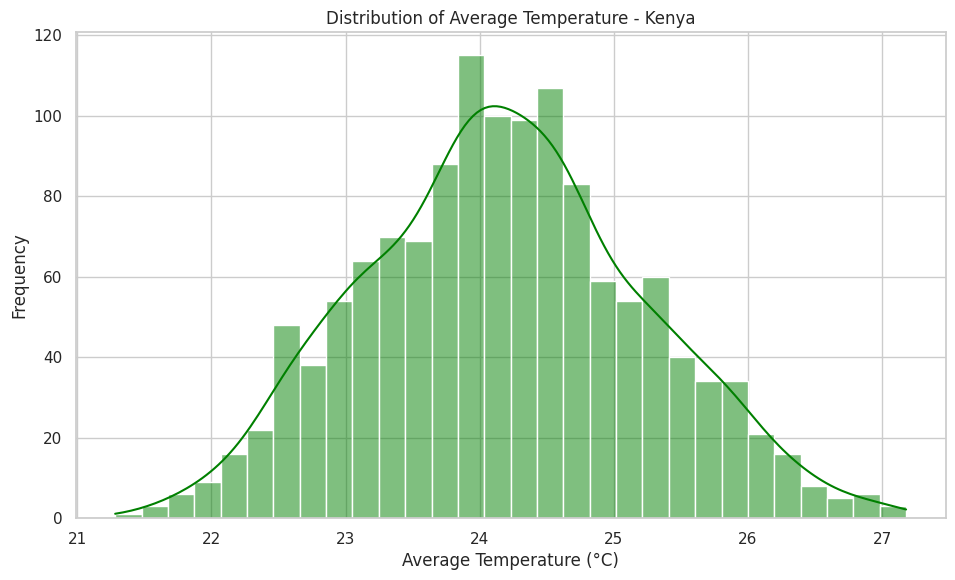

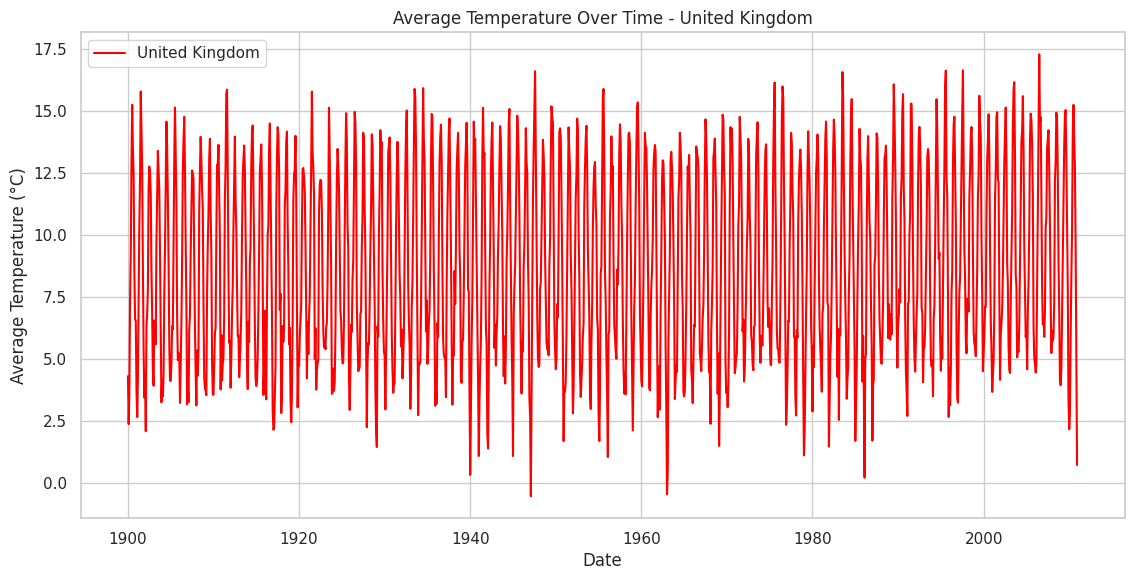

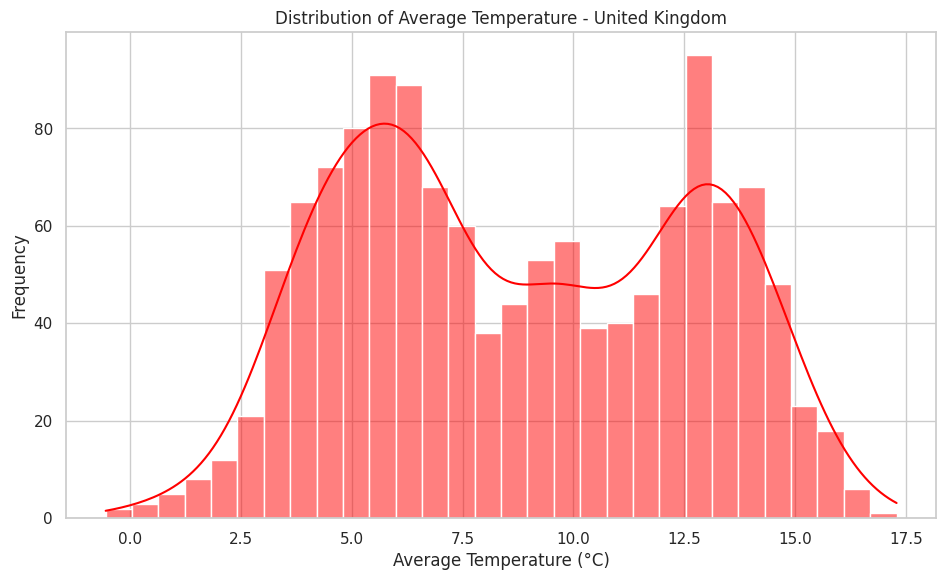

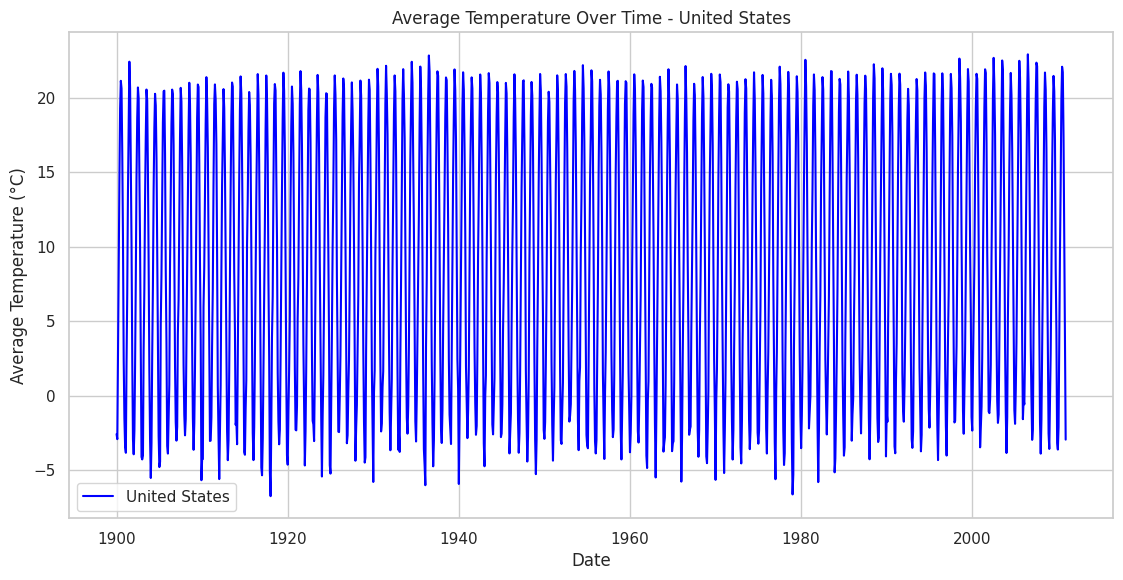

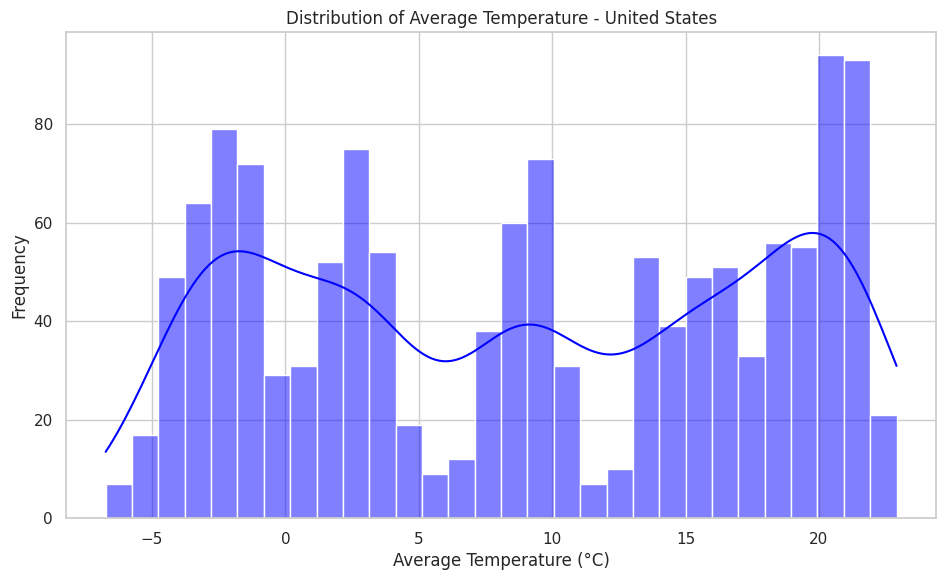

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# List of countries to visualize
countries = ['Brazil', 'India', 'Kenya', 'United Kingdom', 'United States']

# Define colors for each country
colors = {'Brazil': 'purple', 'United Kingdom': 'red', 'United States': 'blue', 'India': 'orange', 'Kenya': 'green'}

# Iterate through each country and create line plots
for country in countries:
    # Filter data for the specific country
    country_data = pandas_df[pandas_df['Country'] == country]

    # Line plot for average temperature over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='dt', y='AverageTemperature', data=country_data, label=country, color=colors[country])
    plt.title(f'Average Temperature Over Time - {country}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (°C)')
    plt.legend()
    plt.show()

    # Histogram for average temperature distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(country_data['AverageTemperature'], bins=30, kde=True, color=colors[country])
    plt.title(f'Distribution of Average Temperature - {country}')
    plt.xlabel('Average Temperature (°C)')
    plt.ylabel('Frequency')
    plt.show()


Skewness in Brazil and India indicates a bias towards warmer temperature. The peak points in United kingdom are 5.5 and 12.5 degree celcius and this shows that temperatures tend to cluster around these values. Kenya appears to be symmetrical with mean temperature of about 24 degree celcius.

Line plot for monthly average temperature for Brazil, India, Kenya, United Kingdom and United States

<ipython-input-40-80a146302472>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])
<ipython-input-40-80a146302472>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Month'] = country_data['dt'].dt.month


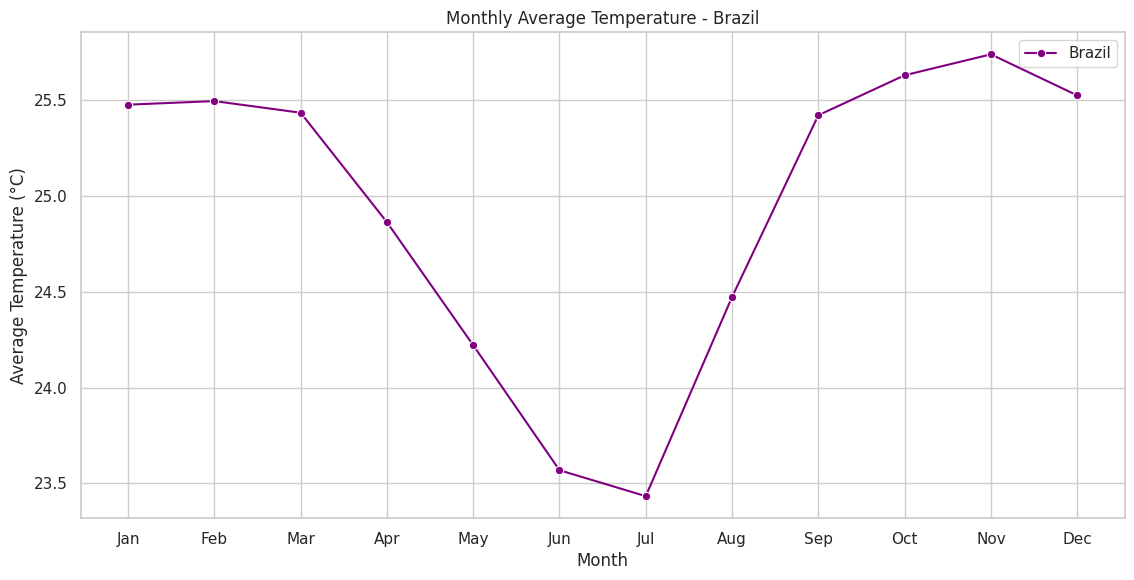

<ipython-input-40-80a146302472>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])
<ipython-input-40-80a146302472>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Month'] = country_data['dt'].dt.month


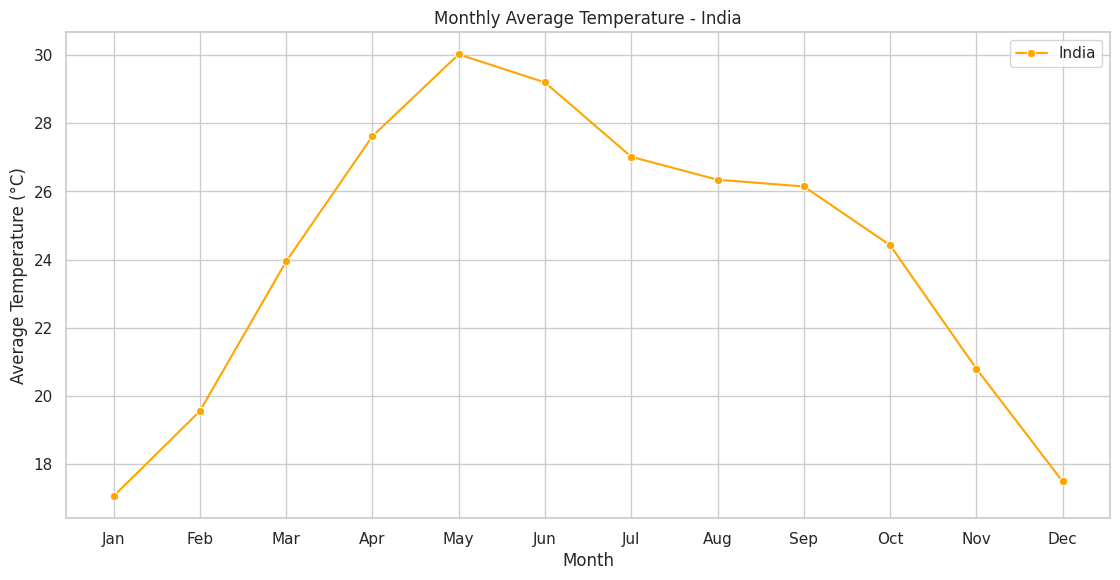

<ipython-input-40-80a146302472>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])
<ipython-input-40-80a146302472>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Month'] = country_data['dt'].dt.month


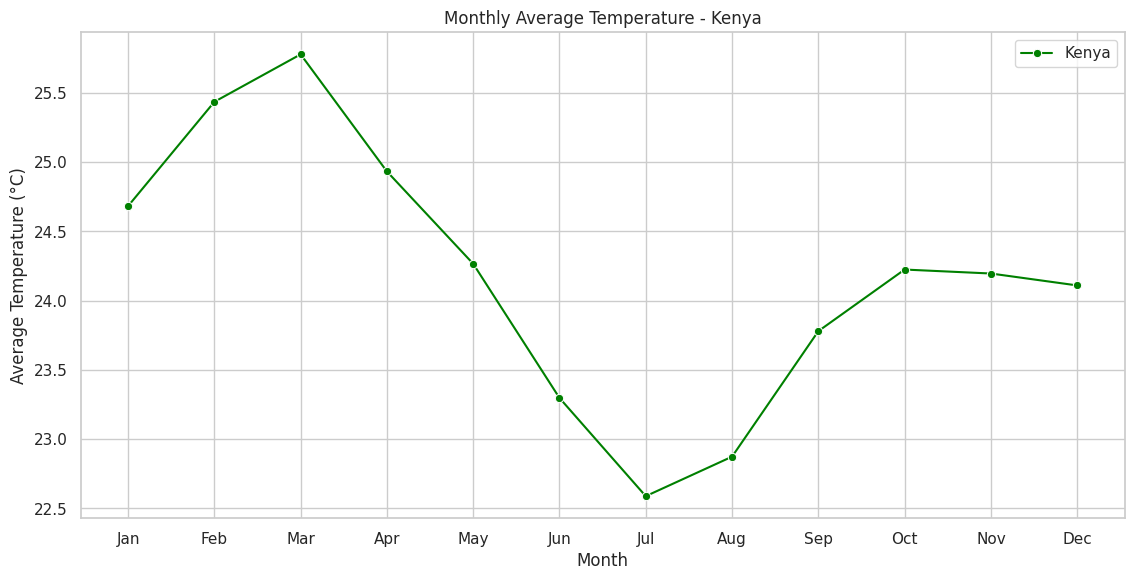

<ipython-input-40-80a146302472>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])
<ipython-input-40-80a146302472>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Month'] = country_data['dt'].dt.month


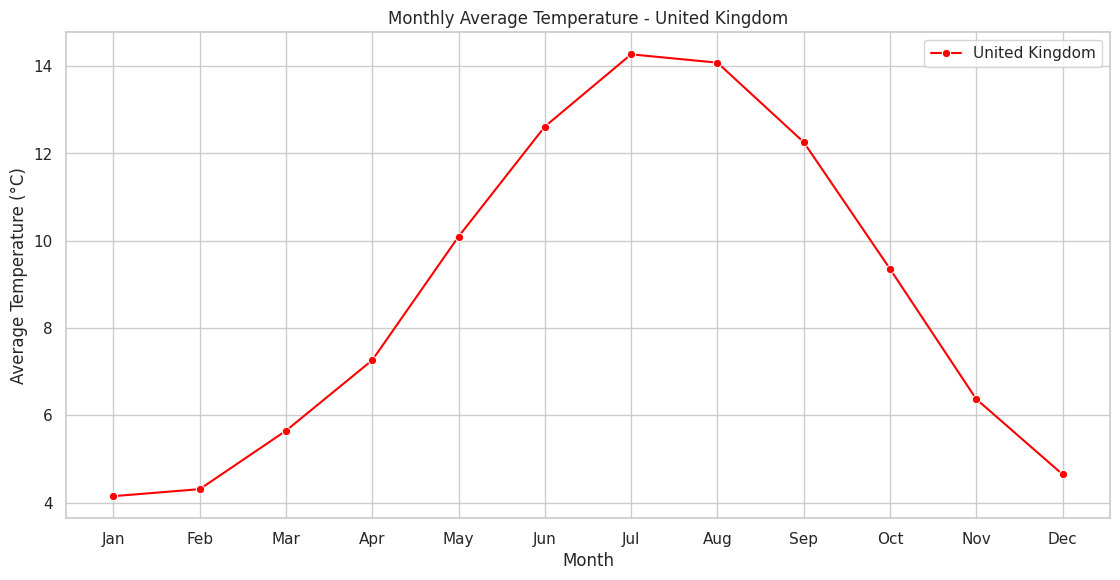

<ipython-input-40-80a146302472>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])
<ipython-input-40-80a146302472>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Month'] = country_data['dt'].dt.month


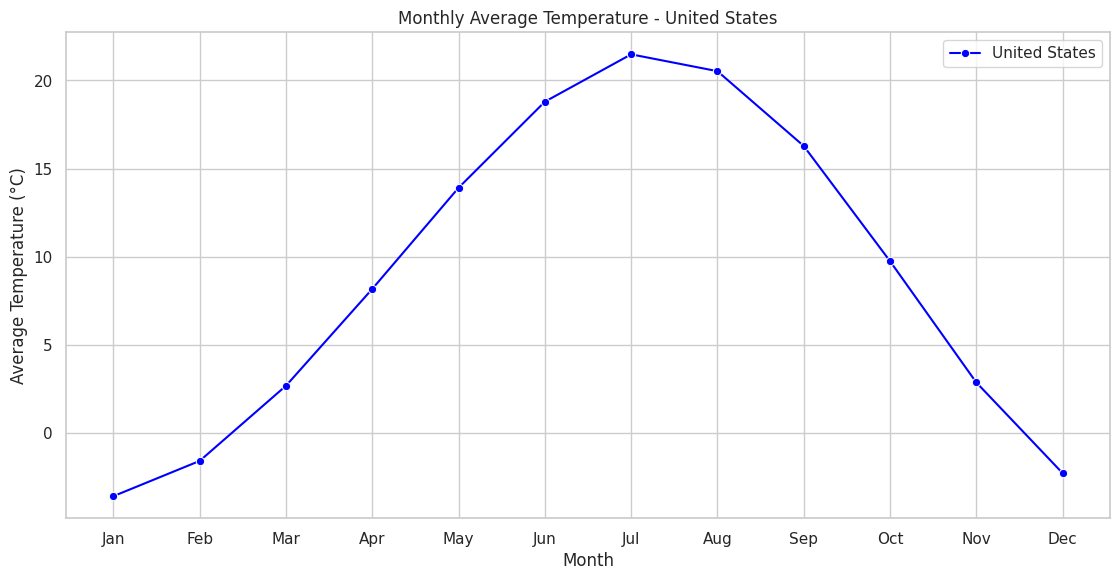

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# List of countries to visualize
countries = ['Brazil', 'India', 'Kenya', 'United Kingdom', 'United States']

# Define colors for each country
colors = {'Brazil': 'purple', 'United Kingdom': 'red', 'United States': 'blue', 'India': 'orange', 'Kenya': 'green'}

# Iterate through each country and create monthly average line plots
for country in countries:
    # Filter data for the specific country
    country_data = pandas_df[pandas_df['Country'] == country]

    # Convert 'dt' column to datetime type
    country_data['dt'] = pd.to_datetime(country_data['dt'])

    # Extract month from the 'dt' column
    country_data['Month'] = country_data['dt'].dt.month

    # Group by month and calculate the average temperature
    monthly_average = country_data.groupby('Month')['AverageTemperature'].mean().reset_index()

    # Line plot for monthly average temperature
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Month', y='AverageTemperature', data=monthly_average, marker='o', label=country, color=colors[country])
    plt.title(f'Monthly Average Temperature - {country}')
    plt.xlabel('Month')
    plt.ylabel('Average Temperature (°C)')
    plt.xticks(range(1, 13), [calendar.month_abbr[i] for i in range(1, 13)])  # Show month names on the x-axis
    plt.legend()
    plt.show()


The line plot above depicts that on the average Brazil in hottest is November, India in May, Kenya in March, UK and US in July.

Us is coldest in January as temperatures drop below zero, Uk is also coldest in the month of January. Brazil and kenya experience their lowest temperatures in July. Both countries can be seen to have similar climate patterns. Despite been located in different continents, their similar proximity to the equator explains their shared climate patterns.

Time Series Decomposition of Average Temperature for Brazil, India, Kenya,

<ipython-input-41-322ae62204e4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])


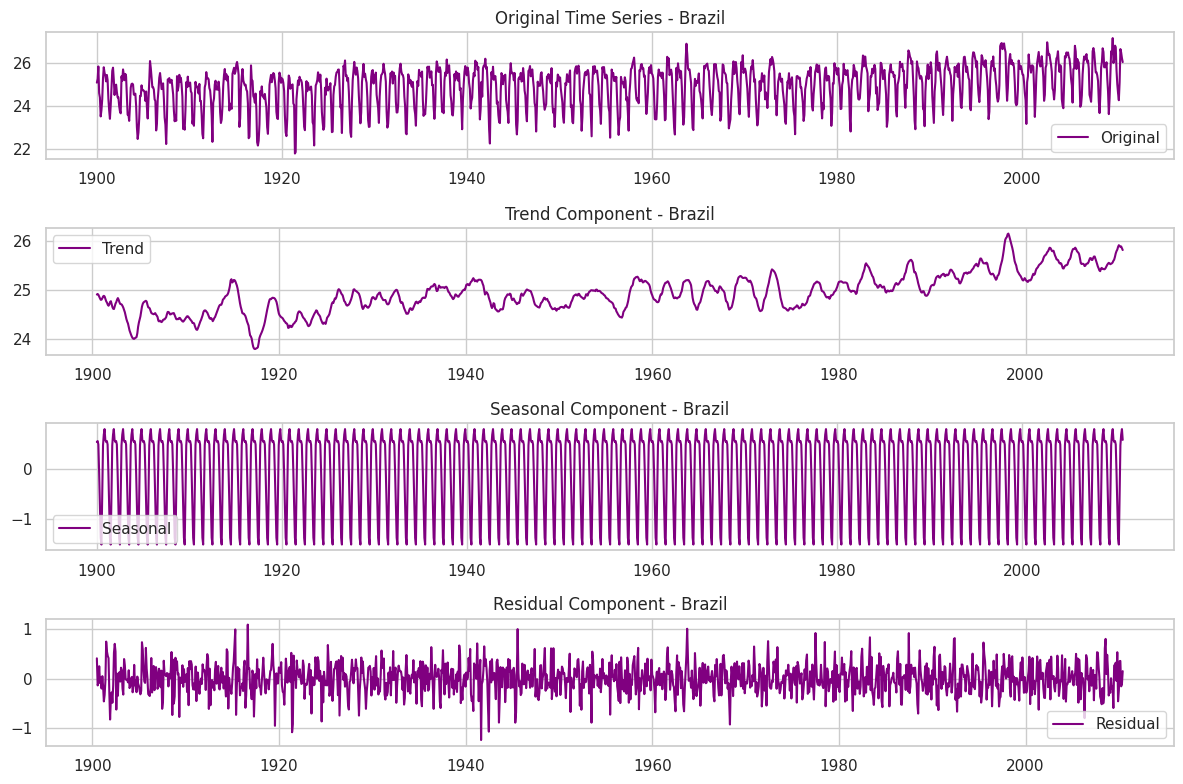

<ipython-input-41-322ae62204e4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])


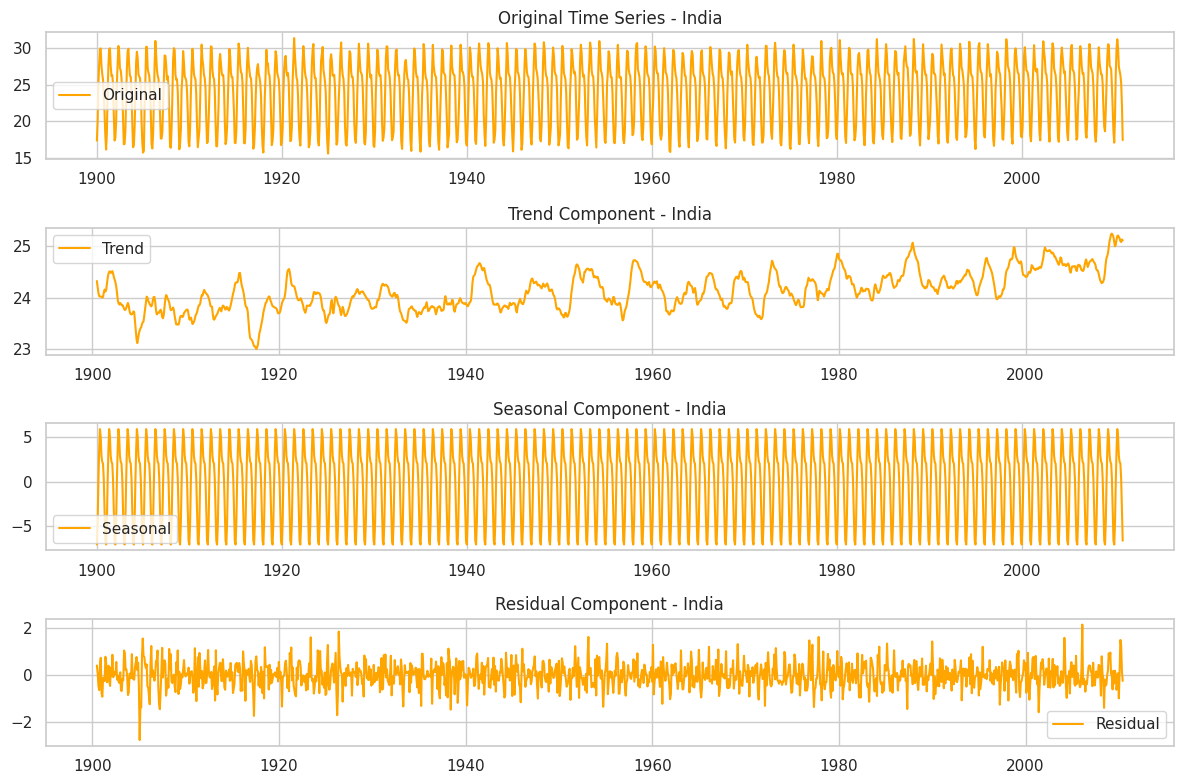

<ipython-input-41-322ae62204e4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])


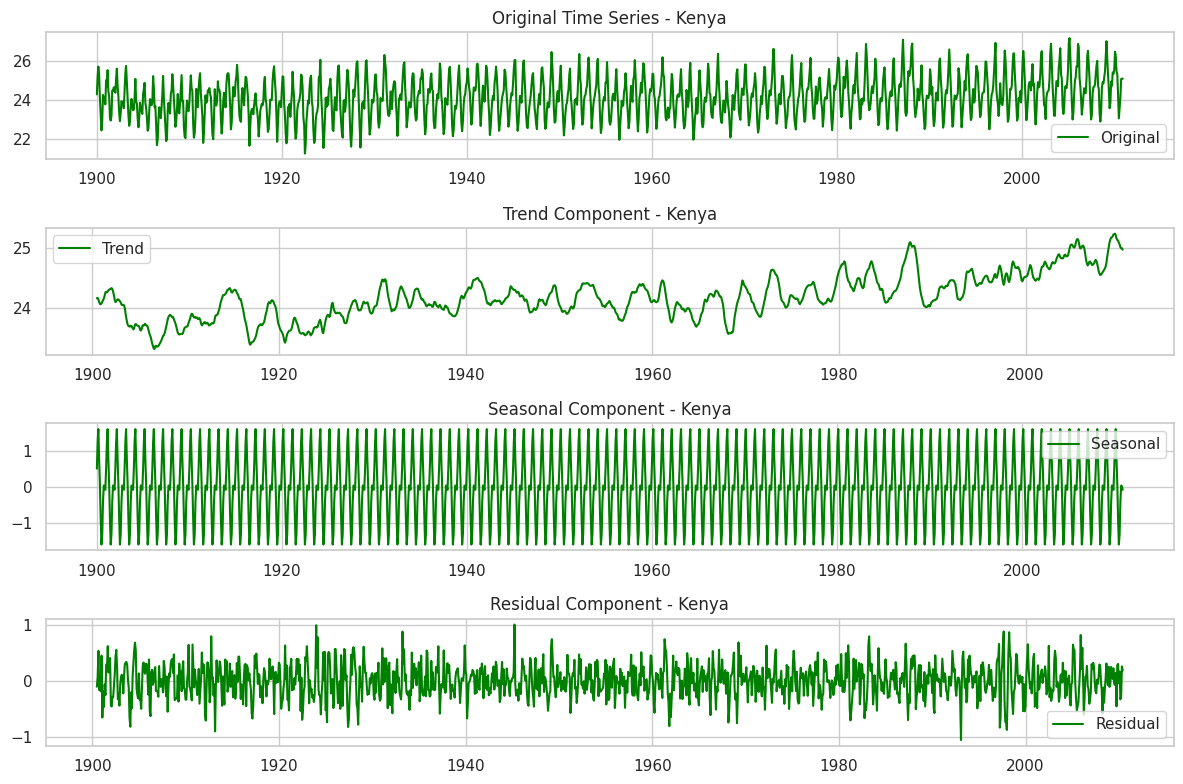

<ipython-input-41-322ae62204e4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])


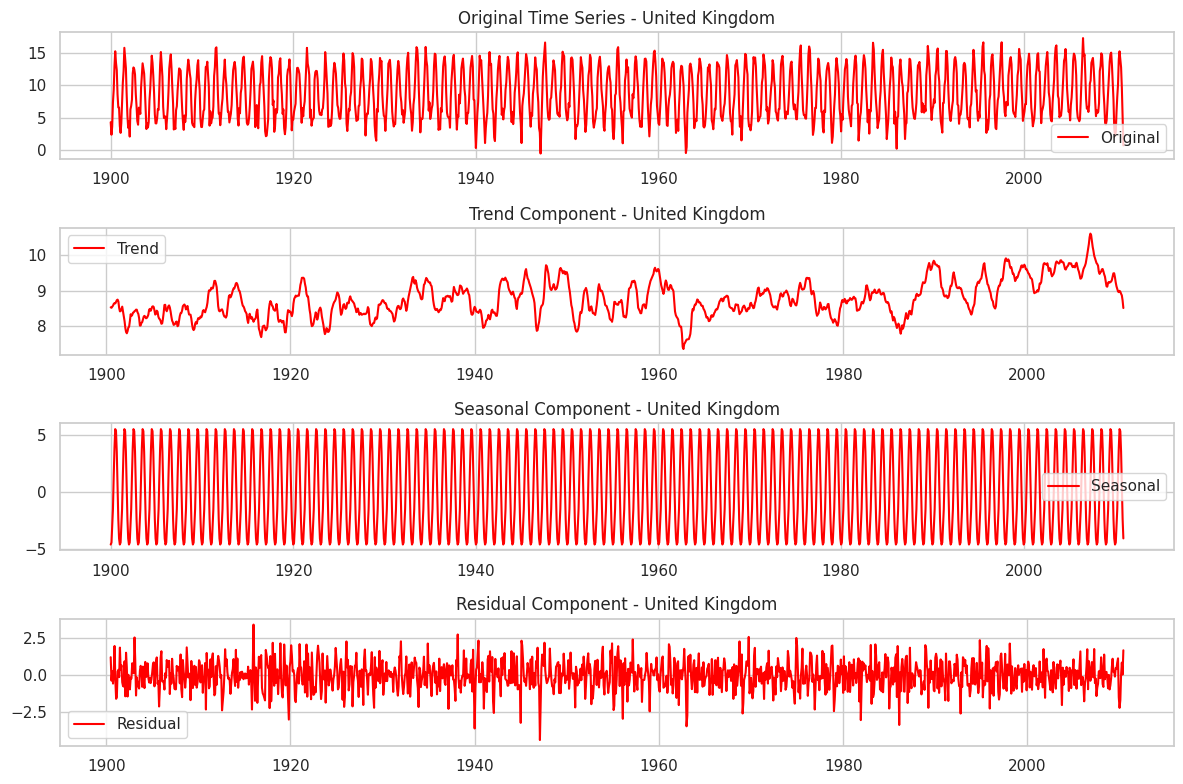

<ipython-input-41-322ae62204e4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['dt'] = pd.to_datetime(country_data['dt'])


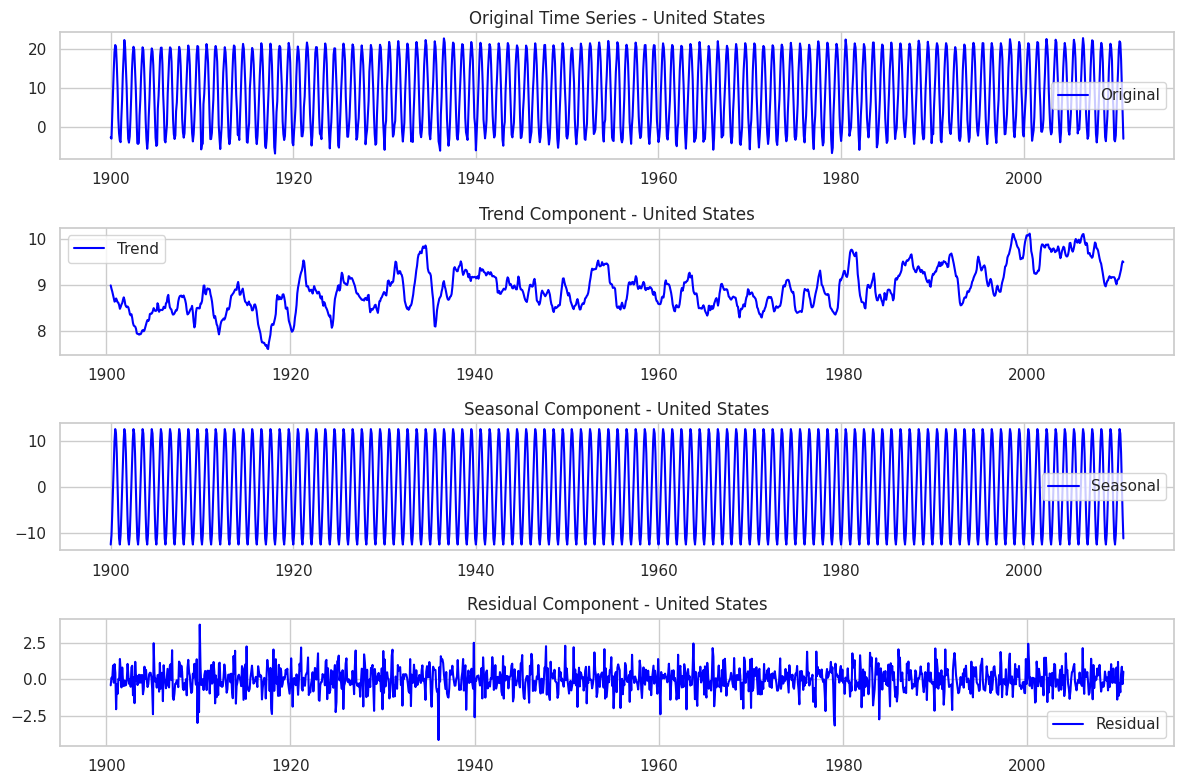

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# List of countries to visualize
countries = ['Brazil', 'India', 'Kenya', 'United Kingdom', 'United States']

# Define colors for each country
colors = {'Brazil': 'purple', 'United Kingdom': 'red', 'United States': 'blue', 'India': 'orange', 'Kenya': 'green'}

#We Iterate through each country and create time series plots
for country in countries:
    # Filter out data for the specific country
    country_data = pandas_df[pandas_df['Country'] == country]

    # Set the 'dt' column as the datetime index
    country_data['dt'] = pd.to_datetime(country_data['dt'])
    country_data.set_index('dt', inplace=True)

    # Decompose the time series into trend, seasonal, and residual components
    decomposition = seasonal_decompose(country_data['AverageTemperature'], period=12)  # Assuming seasonality of 12 months

    # Plot the original time series, trend, seasonal, and residual components
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(country_data['AverageTemperature'], label='Original', color=colors[country])
    plt.title(f'Original Time Series - {country}')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Trend', color=colors[country])
    plt.title(f'Trend Component - {country}')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Seasonal', color=colors[country])
    plt.title(f'Seasonal Component - {country}')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residual', color=colors[country])
    plt.title(f'Residual Component - {country}')
    plt.legend()

    plt.tight_layout()
    plt.show()


Correlation Plot of Variables in Dataset

<Figure size 1500x1000 with 0 Axes>

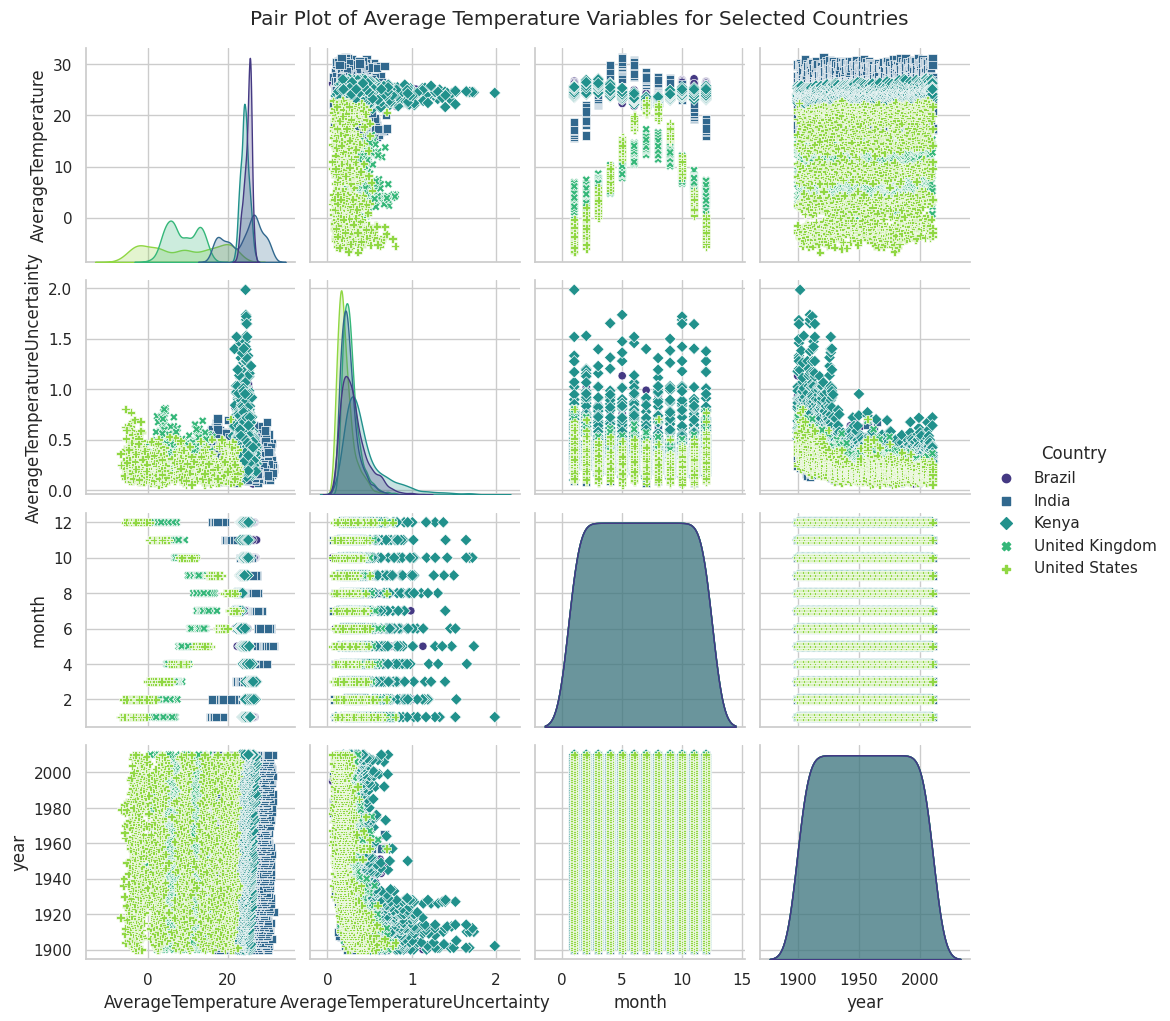

In [ ]:
# List of countries to visualize
countries = ['Brazil', 'India', 'Kenya', 'United Kingdom', 'United States']

# Filter data for the specified countries
selected_countries_data = pandas_df[pandas_df['Country'].isin(countries)]

# Create a pair plot
plt.figure(figsize=(15, 10))
sns.pairplot(selected_countries_data, hue='Country', markers=["o", "s", "D", "X", "P"], palette='viridis')
plt.suptitle('Pair Plot of Average Temperature Variables for Selected Countries', y=1.02)
plt.show()



SPLIT DATAFRAME INTO SEPERATE COUNTRIES

In [ ]:
# List of countries
countries = ['Brazil', 'India', 'Kenya', 'United Kingdom', 'United States']

# Create separate DataFrames for each country
brazil_df = pandas_df[pandas_df['Country'] == 'Brazil']
india_df = pandas_df[pandas_df['Country'] == 'India']
kenya_df = pandas_df[pandas_df['Country'] == 'Kenya']
uk_df = pandas_df[pandas_df['Country'] == 'United Kingdom']
us_df = pandas_df[pandas_df['Country'] == 'United States']

SELECT NECESSARY COLUMNS For Modelling dt and AverageTemperature

In [ ]:
# Select only the necessary columns and set 'dt' as the index
brazil_df_modified = brazil_df[['dt', 'AverageTemperature']].set_index('dt')
india_df_modified = india_df[['dt', 'AverageTemperature']].set_index('dt')
kenya_df_modified = kenya_df[['dt', 'AverageTemperature']].set_index('dt')
uk_df_modified = uk_df[['dt', 'AverageTemperature']].set_index('dt')
us_df_modified = us_df[['dt', 'AverageTemperature']].set_index('dt')


**PEFORM STATIONARITY CHECK USING DICKEY-FULLER TEST**

LET'S DEFINE THE HYPOTHESIS

**Null Hypothesis(H0)**: Series is non-stationary

**Alternate Hypothesis(H1)**: Series is stationary

P-value > 0.05: Fail to reject the null hypothesis (H0)

P-value <= 0.05: Reject the null hypothesis (H0),





STATIONARITY TEST FOR BRAZIL

In [ ]:
result = adfuller(brazil_df_modified['AverageTemperature'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.230824974033721
p-value: 0.19524855248221223
Critical Values:
   1%: -3.435359311744588
   5%: -2.863752202145595
   10%: -2.5679477886494775


Based on the test statistic and p-value: 0.19524855248221223 which is > 0.05

We fail to reject the null hypothesis (H0) at the 5% significance level

The Brazil data does not provide enough evidence to suggest that the time series is stationary.

The Brazil time series may exhibit a unit root, indicating non-stationarity

STATIONARITY TEST FOR INDIA

In [ ]:
result = adfuller(india_df_modified['AverageTemperature'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.276949606131597
p-value: 0.01594079844090175
Critical Values:
   1%: -3.435359311744588
   5%: -2.863752202145595
   10%: -2.5679477886494775


P-value = 0.01594079844090175 which is < 0.05

There is evidence to reject the null hypothesis (H0)

The test statistic falling below the 10% critical value further supports rejecting the null hypothesis.

Hence India is stationary

STATIONARITY TEST FOR KENYA

In [ ]:
result = adfuller(kenya_df_modified['AverageTemperature'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.0412363416346073
p-value: 0.2687900559619558
Critical Values:
   1%: -3.435359311744588
   5%: -2.863752202145595
   10%: -2.5679477886494775


P-value = 0.2687900559619558 which is > 0.05
Hence we fail to reject the null hypothesis (H0)

The tme series data for KENYA does not provide enough evidence to conclude that the time series is stationary.

The time series may exhibit a unit root, indicating non-stationarity

Kenya is non-stationary

STATIONARITY TEST FOR United Kingdom

In [ ]:
result = adfuller(uk_df_modified['AverageTemperature'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -4.336538357186334
p-value: 0.00038376142949503344
Critical Values:
   1%: -3.435359311744588
   5%: -2.863752202145595
   10%: -2.5679477886494775


The test statistic of -4.336538357186334 is more negative than the critical values provided.

The p-value of 0.00038376142949503344 is much less than the common significance level of 0.05.

This means the data for United Kingdom provides enough evidence to suggest that the time series is stationary.

STATIONARITY TEST FOR United States

In [ ]:
result = adfuller(us_df_modified['AverageTemperature'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -4.06231844727216
p-value: 0.0011171435713570761
Critical Values:
   1%: -3.435359311744588
   5%: -2.863752202145595
   10%: -2.5679477886494775


P-value = 0.00038376142949503344 which is < 0.05

Hence we reject the null hypothesis (H0)

The data provides enough evidence to suggest that the time series is stationary, as indicated by the rejection of the null hypothesis.

**APPLY DIFFERENCING ON BRAZIL AND KENYA TO MAKE TIME SERIES STATIONARY**

DIFFERECING FOR BRAZIL

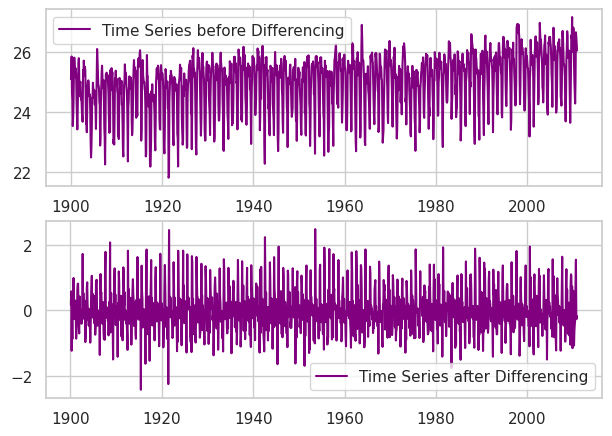

In [ ]:
brazil_diff = brazil_df_modified.diff(periods = 1) # First order differencing
plt.subplot(211)
plt.plot(brazil_df_modified, label='Time Series before Differencing', color='purple')
plt.legend()

plt.subplot(212)
plt.plot(brazil_diff, label='Time Series after Differencing', color='purple')
plt.legend()

plt.show()

STATIONARITY TEST FOR BRAZIL AFTER DIFFERENCING

In [ ]:
brazil_diff.dropna(inplace = True)# Data transformation may add na values
result = adfuller(brazil_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -13.580249509569112
p-value: 2.1306893479864413e-25
Critical Values:
   1%: -3.435363151990756
   5%: -2.863753896647996
   10%: -2.5679486910456264


P-value = 2.130689e-25 which is < 0.05

Hence we reject the null hypothesis(H0)

The data provides strong evidence to suggest that the Brazil time series is now stationary, as indicated by the rejection of the null hypothesis.

DIFFERECING FOR KENYA

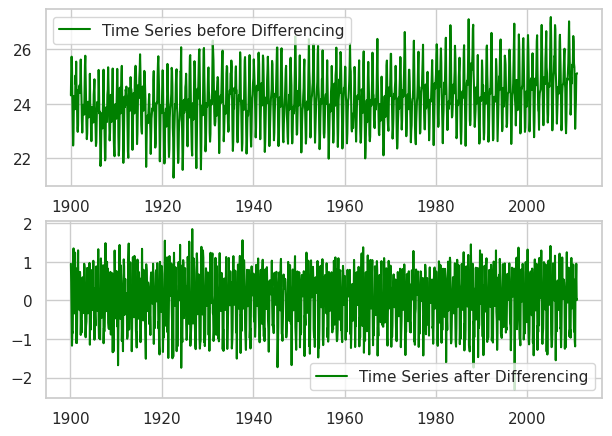

In [ ]:
kenya_diff = kenya_df_modified.diff(periods = 1) # First order differencing
plt.subplot(211)
plt.plot(kenya_df_modified, label='Time Series before Differencing', color='green')
plt.legend()

plt.subplot(212)
plt.plot(kenya_diff, label='Time Series after Differencing', color='green')
plt.legend()

plt.show()

STATIONARITY TEST FOR KENYA AFTER DIFFERENCING

In [ ]:
kenya_diff.dropna(inplace = True)# Data transformation may add na values
result = adfuller(kenya_diff['AverageTemperature'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -11.723699037533418
p-value: 1.3937665795723675e-21
Critical Values:
   1%: -3.435363151990756
   5%: -2.863753896647996
   10%: -2.5679486910456264


P-value = 1.393767e-21 which is < 0.05

Hence we reject the null hypothesis (H0)

Kenya time series is now stationary

Brazil ACF and PACF Plots

[ 1.          0.21917786 -0.04613197 -0.22534425 -0.29449746 -0.12214844
 -0.04164518 -0.11201339 -0.30057519 -0.24339499  0.01317102  0.35398269
  0.60800843  0.37971987 -0.01797341 -0.23921958 -0.28089663 -0.14102549
 -0.0197408  -0.13794995 -0.27390472] [ 1.          0.21919028 -0.09888558 -0.20428443 -0.22467195 -0.04976073
 -0.08921669 -0.23460263 -0.44687262 -0.43885824 -0.40664376 -0.27967725
  0.09853864  0.22144776  0.14498483  0.08723591 -0.02324449 -0.07340303
 -0.00511031 -0.04177626 -0.07177177]


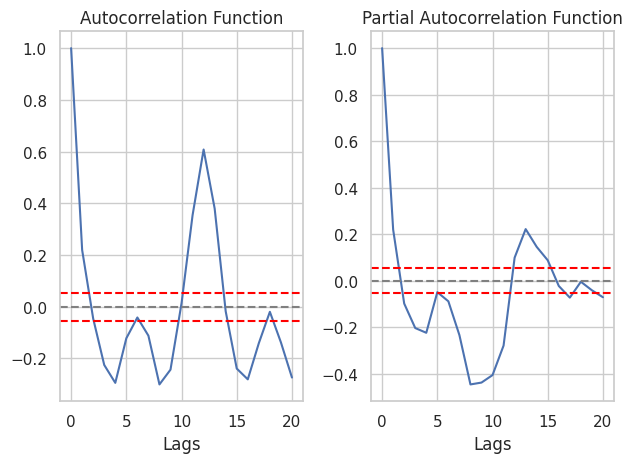

In [ ]:
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

lag_acf_brazil = acf(brazil_diff, nlags=20)
lag_pacf_brazil = pacf(brazil_diff, nlags=20, method='ols')
print(lag_acf_brazil, lag_pacf_brazil)

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf_brazil)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(brazil_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(brazil_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_brazil)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(brazil_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(brazil_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

From Both Plots we Observed P=2 and Q =2 d = 1

However, I tuned the models for each country by adjusting P and Q for optimal model performance. Since P is is the order of the autoregressive (AR) component, and it indicates the number of most recent observations used by the ARIMA model in the forcast.

**ARIMA MODELLING**

Fitting the ARIMA model to time series data for Brazil and plot the original data along with the fitted values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

Text(0.5, 1.0, 'Brazil Original Data and Fitted Values')

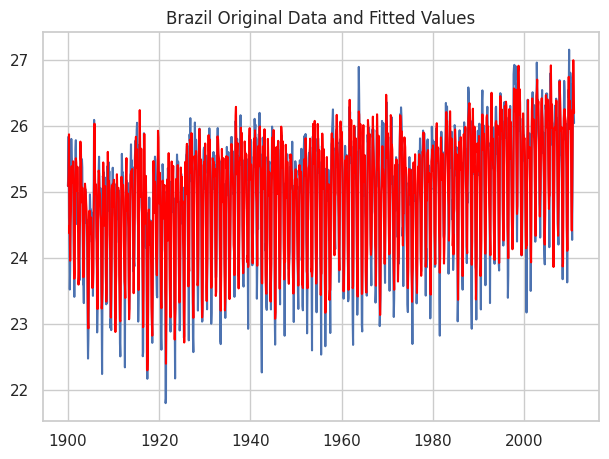

In [ ]:
brazil_model = ARIMA(brazil_df_modified, order=(8, 1, 3))
results_ARIMA_brazil = brazil_model.fit()
plt.plot(brazil_df_modified)
plt.plot(results_ARIMA_brazil.fittedvalues[1:], color='red')
plt.title('Brazil Original Data and Fitted Values')


BRAZIL FITTED VALUES



In [ ]:
predictions_diff = pd.Series(results_ARIMA_brazil.fittedvalues, copy=True)
# Add a column of original data to the predictions_diff Series
predictions_diff = pd.concat([predictions_diff, brazil_df_modified['AverageTemperature']], axis=1)

# Rename the columns
predictions_diff.columns = ['FittedAverageTemperature', 'OriginalAverageTemperature']

#Show the modified DataFrame
print(predictions_diff.tail(20))


            FittedAverageTemperature  OriginalAverageTemperature
dt                                                              
2009-05-01                 24.463133                      24.672
2009-06-01                 24.103378                      23.626
2009-07-01                 24.130368                      24.375
2009-08-01                 25.287417                      25.474
2009-09-01                 26.295381                      26.540
2009-10-01                 26.739351                      26.427
2009-11-01                 26.218314                      27.151
2009-12-01                 26.383166                      25.998
2010-01-01                 25.954557                      26.206
2010-02-01                 26.244959                      26.802
2010-03-01                 26.189638                      26.728
2010-04-01                 25.787331                      25.654
2010-05-01                 24.790497                      25.015
2010-06-01               

BRAZIL TEMPERATURE FORECAST FOR 2010-2015 WITH ARIMA MODEL

In [ ]:
#Convert to datetime
brazil_df_modified.index = pd.to_datetime(brazil_df_modified.index)

#Fit model using original brazil data
brazil_model = ARIMA(brazil_df_modified, order=(8, 1, 3))
results_ARIMA_brazil = brazil_model.fit()

#Set number of periods to forecast into the future
forecast_years = 5  # Adjust as needed
forecast_periods = forecast_years * 12

#Forecast future values
forecast_values = results_ARIMA_brazil.get_forecast(steps=forecast_periods)

#Extract forecasted values and confidence intervals
forecast_mean = forecast_values.predicted_mean
confidence_interval = forecast_values.conf_int()

#Create future dates for the forecast (2011 to 2015)
future_dates = pd.date_range(start=brazil_df_modified.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='MS')

#Merge original data, fitted values, and forecasted values
plot_data = pd.concat([brazil_df_modified, pd.Series(results_ARIMA_brazil.fittedvalues[1:]), pd.Series(forecast_mean, index=future_dates)], axis=1)
plot_data.columns = ['Original Data', 'Fitted Values', 'Forecasted Values']

#Filter data for 2010 to 2015
plot_data_2010_2015 = plot_data['2010':'2015']

#Filter confidence interval data from 2011
confidence_interval_2011 = confidence_interval.loc['2011':]

#Draw traces to use in the line plot.
trace_original = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Original Data'], mode='lines', name='Original Data')
trace_fitted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Fitted Values'], mode='lines', name='Fitted Values')
trace_forecasted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Forecasted Values'], mode='lines', name='Forecasted Values')

#Create traces for the confidence interval
trace_upper = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 1], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Upper Bound')
trace_lower = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 0], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Lower Bound')

#Create the figure
fig = go.Figure(data=[trace_original, trace_fitted, trace_forecasted, trace_upper, trace_lower])

#Update x-axis labels
fig.update_xaxes(type='category', tickmode='array', tickvals=plot_data_2010_2015.index, ticktext=plot_data_2010_2015.index.strftime('%b %Y'))

#Update layout
fig.update_layout(title='Brazil Original Data, Fitted Values, and Forecasted Values (2010 to 2015) with Confidence Interval (from 2011)',
                  xaxis_title='Date',
                  yaxis_title='Temperature',
                  hovermode='x unified')

#Show the plot
fig.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

EVALUATE MODEL'S PERFORMANCE FOR BRAZIL

In [ ]:
#Extract the actual values for the forecasted period
actual_values_brazil = brazil_df_modified['AverageTemperature'][-forecast_periods:]

#R-squared (R2)
r2_brazil = r2_score(actual_values_brazil, forecast_mean)

#Mean Absolute Error (MAE)
mae_brazil = mean_absolute_error(actual_values_brazil, forecast_mean)

#Root Mean Squared Error (RMSE)
rmse_brazil = np.sqrt(mean_squared_error(actual_values_brazil, forecast_mean))

# Print the metrics
print(f'R-squared (R2): {r2_brazil:.4f}')
print(f'Mean Absolute Error (MAE): {mae_brazil:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_brazil:.4f}')


R-squared (R2): 0.7521
Mean Absolute Error (MAE): 0.3533
Root Mean Squared Error (RMSE): 0.4400


PLOT KENYA ACF AND PACF

[ 1.          0.37697656 -0.06615724 -0.33441606 -0.289818   -0.15993643
 -0.05542526 -0.14108528 -0.27328637 -0.31748439 -0.05773918  0.43755789
  0.76510406  0.44417501 -0.06066604 -0.31345983 -0.27624366 -0.14295634
 -0.06677421 -0.13606535 -0.2767269 ] [ 1.          0.37697684 -0.24275241 -0.26323658 -0.08506345 -0.10183036
 -0.11613766 -0.28289143 -0.376473   -0.50329218 -0.50924227 -0.25709664
  0.25537559  0.1651885  -0.03430646 -0.02913428  0.0401745   0.04692943
  0.00388148 -0.03464668 -0.06535179]


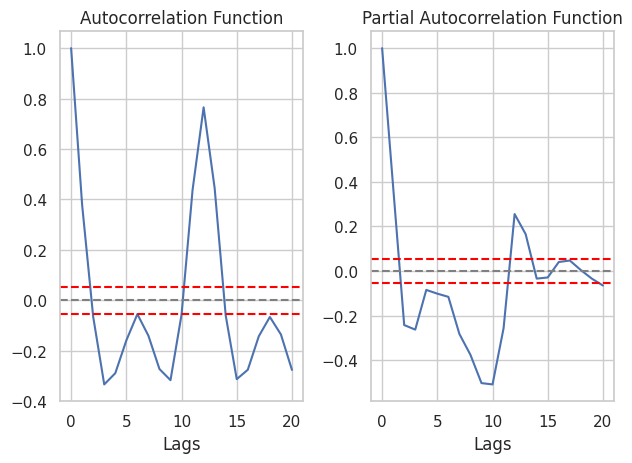

In [ ]:
lag_acf_kenya = acf(kenya_diff, nlags=20)
lag_pacf_kenya = pacf(kenya_diff, nlags=20, method='ols')
print(lag_acf_kenya, lag_pacf_kenya)

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf_kenya)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(kenya_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(kenya_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_kenya)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(kenya_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(kenya_diff)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

FIT THE MODEL FOR KENYA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0.5, 1.0, 'Kenya Original Data and Fitted Values')

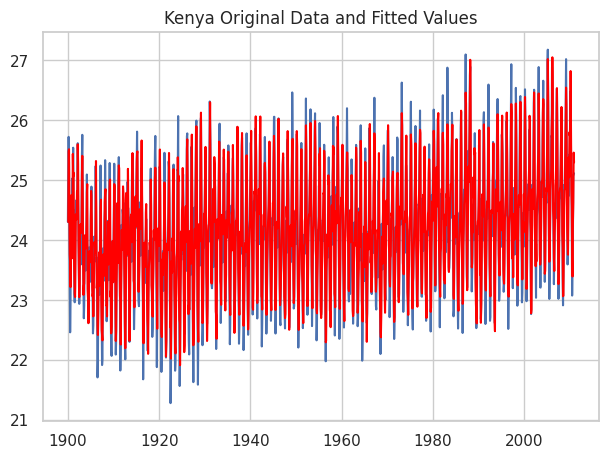

In [ ]:
kenya_model = ARIMA(kenya_df_modified, order=(7, 1, 2))
results_ARIMA_kenya = kenya_model.fit()
plt.plot(kenya_df_modified)
plt.plot(results_ARIMA_kenya.fittedvalues[1:], color='red')
plt.title('Kenya Original Data and Fitted Values')

KENYA FITTED VALUES

In [ ]:
predictions_diff_kenya = pd.Series(results_ARIMA_kenya.fittedvalues, copy=True)
# Add a column of original data to the predictions_diff Series
predictions_diff_kenya = pd.concat([predictions_diff_kenya, kenya_df_modified['AverageTemperature']], axis=1)

# Rename the columns
predictions_diff_kenya.columns = ['FittedAverageTemperature', 'OriginalAverageTemperature']

# Show the modified DataFrame
print(predictions_diff_kenya.tail(20))

            FittedAverageTemperature  OriginalAverageTemperature
dt                                                              
2009-05-01                 24.725593                      25.315
2009-06-01                 24.161740                      24.564
2009-07-01                 23.925545                      23.596
2009-08-01                 23.758183                      23.857
2009-09-01                 24.616665                      24.956
2009-10-01                 25.376844                      24.741
2009-11-01                 25.050383                      25.426
2009-12-01                 25.800552                      25.348
2010-01-01                 25.740839                      25.553
2010-02-01                 26.055720                      26.481
2010-03-01                 26.821330                      26.281
2010-04-01                 25.766151                      25.470
2010-05-01                 24.821428                      25.340
2010-06-01               

KENYA TEMPERATURE FORECAST FOR 2010-2015 WITH ARIMA MODEL

In [ ]:
#Convert to Datetime
kenya_df_modified.index = pd.to_datetime(kenya_df_modified.index)

#Fit the model
kenya_model = ARIMA(kenya_df_modified, order=(7, 1, 2))
results_ARIMA_kenya = kenya_model.fit()

#Set number of periods to forecast into the future
forecast_years = 5  # Adjust as needed
forecast_periods = forecast_years * 12

#Forecast future values
forecast_values_kenya = results_ARIMA_kenya.get_forecast(steps=forecast_periods)

#Extract forecasted values and confidence intervals
forecast_mean_kenya = forecast_values_kenya.predicted_mean
confidence_interval_kenya = forecast_values_kenya.conf_int()

#Create future dates for the forecast (2011 to 2015)
future_dates = pd.date_range(start=kenya_df_modified.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='MS')

#Merge original data, fitted values, and forecasted values
plot_data = pd.concat([kenya_df_modified, pd.Series(results_ARIMA_kenya.fittedvalues[1:]), pd.Series(forecast_mean_kenya, index=future_dates)], axis=1)
plot_data.columns = ['Original Data', 'Fitted Values', 'Forecasted Values']

#Filter data for 2010 to 2015
plot_data_2010_2015 = plot_data['2010':'2015']

#Filter confidence interval data from 2011
confidence_interval_2011 = confidence_interval_kenya.loc['2011':]

#Draw traces to use in the line plot.
trace_original = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Original Data'], mode='lines', name='Original Data')
trace_fitted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Fitted Values'], mode='lines', name='Fitted Values')
trace_forecasted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Forecasted Values'], mode='lines', name='Forecasted Values')

#Create traces for the confidence interval
trace_upper = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 1], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Upper Bound')
trace_lower = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 0], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Lower Bound')

#Create the figure
fig = go.Figure(data=[trace_original, trace_fitted, trace_forecasted, trace_upper, trace_lower])

#Update x-axis labels
fig.update_xaxes(type='category', tickmode='array', tickvals=plot_data_2010_2015.index, ticktext=plot_data_2010_2015.index.strftime('%b %Y'))

#Update layout
fig.update_layout(title='Kenya Original Data, Fitted Values, and Forecasted Values (2010 to 2015) with Confidence Interval (from 2011)',
                  xaxis_title='Date',
                  yaxis_title='Temperature',
                  hovermode='x unified')

# Show the plot
fig.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



EVALUATE MODEL'S PERFORMANCE FOR KENYA

In [ ]:
# Extract the actual values for the forecasted period
actual_values_kenya = kenya_df_modified['AverageTemperature'][-forecast_periods:]

#R-squared (R2)
r2_kenya = r2_score(actual_values_kenya, forecast_mean_kenya)

#Mean Absolute Error (MAE)
mae_kenya = mean_absolute_error(actual_values_kenya, forecast_mean_kenya)

#Root Mean Squared Error (RMSE)
rmse_kenya = np.sqrt(mean_squared_error(actual_values_kenya, forecast_mean_kenya))

# Print the metrics
print(f'R-squared (R2): {r2_kenya:.4f}')
print(f'Mean Absolute Error (MAE): {mae_kenya:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_kenya:.4f}')

R-squared (R2): 0.7641
Mean Absolute Error (MAE): 0.3992
Root Mean Squared Error (RMSE): 0.4910


INDIA ACF AND PACF PLOT

[ 1.          0.80871157  0.37530586 -0.10586846 -0.47535262 -0.68087529
 -0.74386425 -0.68201291 -0.47556858 -0.10512394  0.37392369  0.80008809
  0.97142462  0.79514485  0.36769774 -0.10833308 -0.47397722 -0.67709898
 -0.73950186 -0.67728356 -0.47270777] [ 1.          0.81018403 -0.81698637  0.00670781 -0.12576667 -0.42244413
 -0.48029588 -0.42098894 -0.2734577   0.05561398  0.40078461  0.56275577
  0.3939998  -0.00339458 -0.15848924 -0.06936967 -0.06770679 -0.057054
 -0.05655385 -0.00673087 -0.05901101]


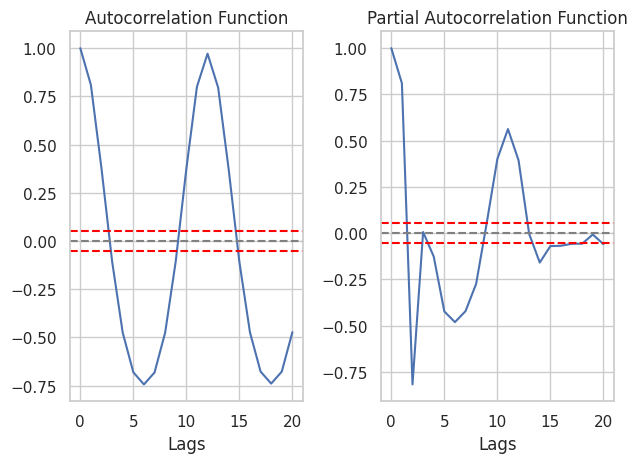

In [ ]:
lag_acf_india = acf(india_df_modified, nlags=20)
lag_pacf_india = pacf(india_df_modified, nlags=20, method='ols')
print(lag_acf_india, lag_pacf_india)

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf_india)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(india_df_modified)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(india_df_modified)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_india)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(india_df_modified)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(india_df_modified)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

FIT THE MODEL FOR INDIA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0.5, 1.0, 'India Original Data and Fitted Values')

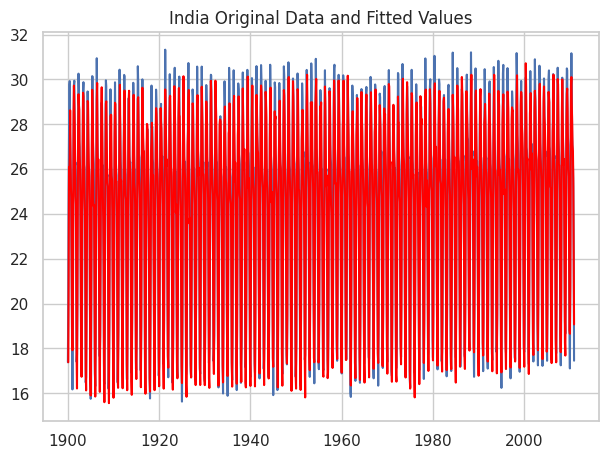

In [ ]:
india_model = ARIMA(india_df_modified, order=(6, 1, 5))
results_ARIMA_india = india_model.fit()
plt.plot(india_df_modified)
plt.plot(results_ARIMA_india.fittedvalues[1:], color='red')
plt.title('India Original Data and Fitted Values')

FITTED VALUES FOR INDIA

In [ ]:
predictions_diff_india = pd.Series(results_ARIMA_india.fittedvalues, copy=True)
# Add a column of original data to the predictions_diff Series
predictions_diff_india = pd.concat([predictions_diff_india, india_df_modified['AverageTemperature']], axis=1)

# Rename the columns
predictions_diff_india.columns = ['FittedAverageTemperature', 'OriginalAverageTemperature']

# Show the modified DataFrame
print(predictions_diff_india.tail(20))

            FittedAverageTemperature  OriginalAverageTemperature
dt                                                              
2009-05-01                 29.355155                      30.493
2009-06-01                 29.592122                      30.409
2009-07-01                 28.685042                      27.611
2009-08-01                 26.812373                      27.379
2009-09-01                 26.000653                      27.080
2009-10-01                 25.670740                      24.775
2009-11-01                 22.015302                      21.457
2009-12-01                 18.815923                      18.631
2010-01-01                 18.655499                      17.109
2010-02-01                 20.710872                      20.764
2010-03-01                 25.166235                      26.373
2010-04-01                 29.770673                      29.814
2010-05-01                 30.107867                      31.169
2010-06-01               

INDIA TEMPERATURE FORECAST 2010-2015 WITH ARIMA MODEL





In [ ]:
#Convert to Datetime
india_df_modified.index = pd.to_datetime(india_df_modified.index)

#Fit the model
india_model = ARIMA(india_df_modified, order=(6, 1, 5))
results_ARIMA_india = india_model.fit()

#Set number of periods to forecast into the future
forecast_years = 5  # Adjust as needed
forecast_periods = forecast_years * 12

#Forecast future values
forecast_values_india = results_ARIMA_india.get_forecast(steps=forecast_periods)

#Extract forecasted values and confidence intervals
forecast_mean_india = forecast_values_india.predicted_mean
confidence_interval_india = forecast_values_india.conf_int()

#Create future dates for the forecast (2011 to 2015)
future_dates = pd.date_range(start=india_df_modified.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='MS')

# Merge original data, fitted values, and forecasted values
plot_data = pd.concat([india_df_modified, pd.Series(results_ARIMA_india.fittedvalues[1:]), pd.Series(forecast_mean_india, index=future_dates)], axis=1)
plot_data.columns = ['Original Data', 'Fitted Values', 'Forecasted Values']

# Filter data for 2010 to 2015
plot_data_2010_2015 = plot_data['2010':'2015']

# Filter confidence interval data from 2011
confidence_interval_2011 = confidence_interval_india.loc['2011':]

# Draw traces to use in the line plot.
trace_original = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Original Data'], mode='lines', name='Original Data')
trace_fitted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Fitted Values'], mode='lines', name='Fitted Values')
trace_forecasted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Forecasted Values'], mode='lines', name='Forecasted Values')

# Create traces for the confidence interval
trace_upper = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 1], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Upper Bound')
trace_lower = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 0], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Lower Bound')

# Create the figure
fig = go.Figure(data=[trace_original, trace_fitted, trace_forecasted, trace_upper, trace_lower])

# Update x-axis labels
fig.update_xaxes(type='category', tickmode='array', tickvals=plot_data_2010_2015.index, ticktext=plot_data_2010_2015.index.strftime('%b %Y'))

# Update layout
fig.update_layout(title='India Original Data, Fitted Values, and Forecasted Values (2010 to 2015) with Confidence Interval (from 2011)',
                  xaxis_title='Date',
                  yaxis_title='Temperature',
                  hovermode='x unified')

# Show the plot
fig.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
# Extract the actual values for the forecasted period
actual_values_india = india_df_modified['AverageTemperature'][-forecast_periods:]

# Calculate R-squared (R2)
r2_india = r2_score(actual_values_india, forecast_mean_india)

# Calculate Mean Absolute Error (MAE)
mae_india = mean_absolute_error(actual_values_india, forecast_mean_india)

# Calculate Root Mean Squared Error (RMSE)
rmse_india = np.sqrt(mean_squared_error(actual_values_india, forecast_mean_india))

# Print the metrics
print(f'R-squared (R2): {r2_india:.4f}')
print(f'Mean Absolute Error (MAE): {mae_india:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_india:.4f}')


R-squared (R2): 0.9519
Mean Absolute Error (MAE): 0.7143
Root Mean Squared Error (RMSE): 0.9027


UK ACF AND PACF PLOT

[ 1.          0.81272708  0.4576073  -0.00217368 -0.45186134 -0.77074329
 -0.88093849 -0.76179069 -0.44210339  0.00159643  0.45468592  0.79075627
  0.9125417   0.78759231  0.4446309  -0.01205663 -0.4468932  -0.75962322
 -0.86905537 -0.75039896 -0.44010748] [ 1.          0.81539331 -0.60701381 -0.51584488 -0.41143998 -0.27339378
 -0.18822365 -0.13792218 -0.01767439  0.14612451  0.27722306  0.29771117
  0.21806354  0.1289902  -0.05326041 -0.11009714  0.00102118 -0.01813636
 -0.0203154  -0.04901828 -0.10924561]


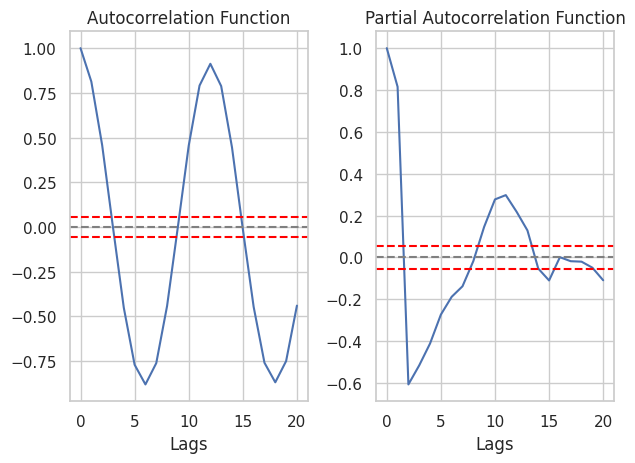

In [ ]:
lag_acf_uk = acf(uk_df_modified, nlags=20)
lag_pacf_uk = pacf(uk_df_modified, nlags=20, method='ols')
print(lag_acf_uk, lag_pacf_uk)

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf_uk)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(uk_df_modified)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(uk_df_modified)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_uk)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(uk_df_modified)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(uk_df_modified)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0.5, 1.0, 'UK Original Data and Fitted Values')

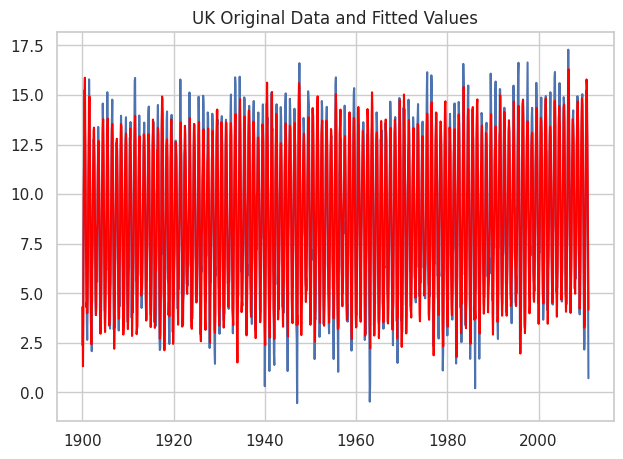

In [ ]:
uk_model = ARIMA(uk_df_modified, order=(6, 1, 2))
results_ARIMA_uk = uk_model.fit()
plt.plot(uk_df_modified)
plt.plot(results_ARIMA_uk.fittedvalues[1:], color='red')
plt.title('UK Original Data and Fitted Values')

Fitted Values for United Kingdom

In [ ]:
predictions_diff_uk = pd.Series(results_ARIMA_uk.fittedvalues, copy=True)
# Add a column of original data to the predictions_diff Series
predictions_diff_uk = pd.concat([predictions_diff_uk, uk_df_modified['AverageTemperature']], axis=1)

# Rename the columns
predictions_diff_uk.columns = ['FittedAverageTemperature', 'OriginalAverageTemperature']

# Show the modified DataFrame
print(predictions_diff_uk.tail(20))

            FittedAverageTemperature  OriginalAverageTemperature
dt                                                              
2009-05-01                 12.187155                      11.060
2009-06-01                 13.826930                      13.612
2009-07-01                 14.834721                      14.787
2009-08-01                 14.491573                      15.040
2009-09-01                 13.189198                      13.049
2009-10-01                 10.526822                      10.495
2009-11-01                  7.840132                       7.740
2009-12-01                  5.542023                       3.379
2010-01-01                  3.255815                       2.156
2010-02-01                  3.407120                       2.836
2010-03-01                  5.390222                       5.798
2010-04-01                  9.008790                       8.221
2010-05-01                 11.909735                      10.105
2010-06-01               

UNITED KINGDOM TEMPERATURE FORECAST 2010-2015 WITH ARIMA MODEL


In [ ]:
uk_df_modified.index = pd.to_datetime(uk_df_modified.index)

# Assuming 'uk_df_modified' is your original DataFrame
uk_model = ARIMA(uk_df_modified, order=(6, 0, 2))
results_ARIMA_uk = uk_model.fit()

# Number of periods to forecast into the future
forecast_years = 5  # Adjust as needed
forecast_periods = forecast_years * 12

# Forecast future values
forecast_values_uk = results_ARIMA_uk.get_forecast(steps=forecast_periods)

# Extract forecasted values and confidence intervals
forecast_mean_uk = forecast_values_uk.predicted_mean
confidence_interval_uk = forecast_values_uk.conf_int()

# Create future dates for the forecast (2011 to 2015)
future_dates = pd.date_range(start=uk_df_modified.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='MS')

# Merge original data, fitted values, and forecasted values
plot_data = pd.concat([uk_df_modified, pd.Series(results_ARIMA_uk.fittedvalues[1:]), pd.Series(forecast_mean_uk, index=future_dates)], axis=1)
plot_data.columns = ['Original Data', 'Fitted Values', 'Forecasted Values']

# Filter data for 2010 to 2015
plot_data_2010_2015 = plot_data['2010':'2015']

# Filter confidence interval data from 2011
confidence_interval_2011 = confidence_interval_uk.loc['2011':]

# Draw traces to use in the line plot.
trace_original = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Original Data'], mode='lines', name='Original Data')
trace_fitted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Fitted Values'], mode='lines', name='Fitted Values')
trace_forecasted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Forecasted Values'], mode='lines', name='Forecasted Values')

# Create traces for the confidence interval
trace_upper = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 1], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Upper Bound')
trace_lower = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 0], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Lower Bound')

# Create the figure
fig = go.Figure(data=[trace_original, trace_fitted, trace_forecasted, trace_upper, trace_lower])

# Update x-axis labels
fig.update_xaxes(type='category', tickmode='array', tickvals=plot_data_2010_2015.index, ticktext=plot_data_2010_2015.index.strftime('%b %Y'))

# Update layout
fig.update_layout(title='UK Original Data, Fitted Values, and Forecasted Values (2010 to 2015) with Confidence Interval (from 2011)',
                  xaxis_title='Date',
                  yaxis_title='Temperature',
                  hovermode='x unified')

# Show the plot
fig.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



EVALUATE MODEL PERFORMANCE FOR UK

In [ ]:
# Extract the actual values for the forecasted period
actual_values_uk = uk_df_modified['AverageTemperature'][-forecast_periods:]

# Calculate R-squared (R2)
r2_uk = r2_score(actual_values_uk, forecast_mean_uk)

# Calculate Mean Absolute Error (MAE)
mae_uk = mean_absolute_error(actual_values_uk, forecast_mean_uk)

# Calculate Root Mean Squared Error (RMSE)
rmse_uk = np.sqrt(mean_squared_error(actual_values_uk, forecast_mean_uk))

# Print the metrics
print(f'R-squared (R2): {r2_uk:.4f}')
print(f'Mean Absolute Error (MAE): {mae_uk:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_uk:.4f}')


R-squared (R2): 0.8571
Mean Absolute Error (MAE): 1.2643
Root Mean Squared Error (RMSE): 1.5442


UNITED STATES MODELLING

US ACF AND PACF

[ 1.00000000e+00  8.56318998e-01  4.91691357e-01 -2.01368758e-03
 -4.91732280e-01 -8.47340277e-01 -9.76402287e-01 -8.44892041e-01
 -4.88589386e-01 -1.70625375e-04  4.90050831e-01  8.49801043e-01
  9.80713077e-01  8.46870112e-01  4.86177838e-01 -3.08038416e-03
 -4.87820536e-01 -8.40312798e-01 -9.67290124e-01 -8.37206105e-01
 -4.83699064e-01] [ 1.          0.85746471 -0.91536509 -0.62399153 -0.40105119 -0.27050716
 -0.24881958 -0.16911358 -0.06608407  0.16158313  0.32208525  0.38008282
  0.28674652  0.11218563 -0.02908724 -0.10583737 -0.05303947 -0.04076158
  0.00178763 -0.06677619 -0.0699835 ]


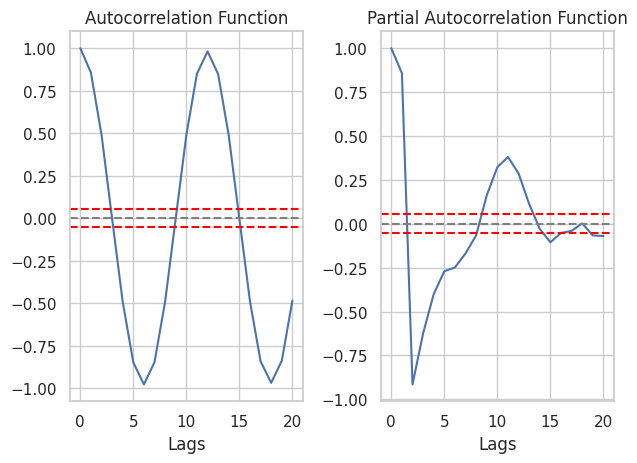

In [ ]:
lag_acf_us = acf(us_df_modified, nlags=20)
lag_pacf_us = pacf(us_df_modified, nlags=20, method='ols')
print(lag_acf_us, lag_pacf_us)

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf_us)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(us_df_modified)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(us_df_modified)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf_us)
plt.axhline(y=0,linestyle='--',color='gray')
# Draw 95% confidence interval line
plt.axhline(y=-1.96/np.sqrt(len(us_df_modified)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(us_df_modified)),linestyle='--',color='red')
plt.xlabel('Lags')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

FIT MODEL

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0.5, 1.0, 'UK Original Data and Fitted Values')

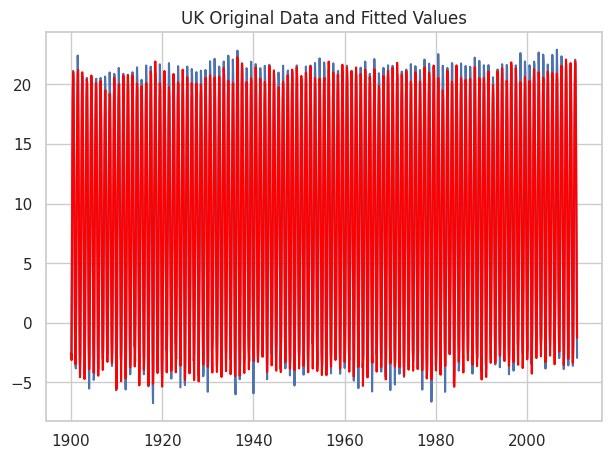

In [ ]:
us_model = ARIMA(us_df_modified, order=(6, 1, 2))
results_ARIMA_us = us_model.fit()
plt.plot(us_df_modified)
plt.plot(results_ARIMA_us.fittedvalues[1:], color='red')
plt.title('UK Original Data and Fitted Values')

FITTED VALUES FOR UK

In [ ]:
predictions_diff_us = pd.Series(results_ARIMA_us.fittedvalues, copy=True)
# Add a column of original data to the predictions_diff Series
predictions_diff_us = pd.concat([predictions_diff_us, us_df_modified['AverageTemperature']], axis=1)

# Rename the columns
predictions_diff_us.columns = ['FittedAverageTemperature', 'OriginalAverageTemperature']

# Show the modified DataFrame
print(predictions_diff_us.tail(20))

            FittedAverageTemperature  OriginalAverageTemperature
dt                                                              
2009-05-01                 14.937975                      14.884
2009-06-01                 20.020712                      18.962
2009-07-01                 21.786777                      21.463
2009-08-01                 20.242990                      20.436
2009-09-01                 16.367929                      17.167
2009-10-01                 11.081900                       8.534
2009-11-01                  3.537039                       4.251
2009-12-01                 -0.420736                      -3.178
2010-01-01                 -3.344135                      -3.610
2010-02-01                 -1.542339                      -2.105
2010-03-01                  2.894808                       3.436
2010-04-01                 10.084498                       9.550
2010-05-01                 15.884167                      14.174
2010-06-01               

UNITED STATES TEMPERATURE FORECAST 2010-2015 WITH ARIMA MODEL


In [ ]:
us_df_modified.index = pd.to_datetime(us_df_modified.index)

# Assuming 'us_df_modified' is your original DataFrame
us_model = ARIMA(us_df_modified, order=(6, 0, 3))
results_ARIMA_us = us_model.fit()

# Number of periods to forecast into the future
forecast_years = 5  # Adjust as needed
forecast_periods = forecast_years * 12

# Forecast future values
forecast_values_us = results_ARIMA_us.get_forecast(steps=forecast_periods)

# Extract forecasted values and confidence intervals
forecast_mean_us = forecast_values_us.predicted_mean
confidence_interval_us = forecast_values_us.conf_int()

# Create future dates for the forecast (2011 to 2015)
future_dates = pd.date_range(start=us_df_modified.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='MS')

# Merge original data, fitted values, and forecasted values
plot_data = pd.concat([us_df_modified, pd.Series(results_ARIMA_us.fittedvalues[1:]), pd.Series(forecast_mean_us, index=future_dates)], axis=1)
plot_data.columns = ['Original Data', 'Fitted Values', 'Forecasted Values']

# Filter data for 2010 to 2015
plot_data_2010_2015 = plot_data['2010':'2015']

# Filter confidence interval data from 2011
confidence_interval_2011 = confidence_interval_us.loc['2011':]

# Draw traces to use in the line plot.
trace_original = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Original Data'], mode='lines', name='Original Data')
trace_fitted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Fitted Values'], mode='lines', name='Fitted Values')
trace_forecasted = go.Scatter(x=plot_data_2010_2015.index, y=plot_data_2010_2015['Forecasted Values'], mode='lines', name='Forecasted Values')

# Create traces for the confidence interval
trace_upper = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 1], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Upper Bound')
trace_lower = go.Scatter(x=confidence_interval_2011.index, y=confidence_interval_2011.iloc[:, 0], fill='tonexty', fillcolor='rgba(0,100,80,0.2)', line=dict(color='rgba(255,255,255,0)'), showlegend=False, name='Lower Bound')

# Create the figure
fig = go.Figure(data=[trace_original, trace_fitted, trace_forecasted, trace_upper, trace_lower])

# Update x-axis labels
fig.update_xaxes(type='category', tickmode='array', tickvals=plot_data_2010_2015.index, ticktext=plot_data_2010_2015.index.strftime('%b %Y'))

# Update layout
fig.update_layout(title='US Original Data, Fitted Values, and Forecasted Values (2010 to 2015) with Confidence Interval (from 2011)',
                  xaxis_title='Date',
                  yaxis_title='Temperature',
                  hovermode='x unified')

# Show the plot
fig.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



EVALUATE MODEL'S PERFORMANCE FOR UNITED STATES

In [ ]:
# Extract the actual values for the forecasted period
actual_values_us = us_df_modified['AverageTemperature'][-forecast_periods:]

#Calculate R-squared (R2)
r2_us = r2_score(actual_values_us, forecast_mean_us)

#Calculate Mean Absolute Error (MAE)
mae_us = mean_absolute_error(actual_values_us, forecast_mean_us)

#Calculate Root Mean Squared Error (RMSE)
rmse_us = np.sqrt(mean_squared_error(actual_values_us, forecast_mean_us))

#Print the metrics
print(f'R-squared (R2): {r2_us:.4f}')
print(f'Mean Absolute Error (MAE): {mae_us:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_us:.4f}')

R-squared (R2): 0.9851
Mean Absolute Error (MAE): 0.8276
Root Mean Squared Error (RMSE): 1.0941


Dataframe For Evaluation Metrics

In [ ]:
#DataFrame with the evaluation metrics
metrics_data = {
    'Country': ['Brazil', 'India', 'Kenya', 'United Kingdom', 'United States'],
    'R2': [r2_brazil, r2_india, r2_kenya, r2_uk, r2_us],
    'MAE': [mae_brazil, mae_india, mae_kenya, mae_uk, mae_us],
    'RMSE': [rmse_brazil, rmse_india, rmse_kenya, rmse_uk, rmse_us]
}
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)


          Country        R2       MAE      RMSE
0          Brazil  0.752056  0.353251  0.439985
1           India  0.951887  0.714292  0.902704
2           Kenya  0.764109  0.399173  0.490954
3  United Kingdom  0.857128  1.264301  1.544171
4   United States  0.985055  0.827577  1.094081
